#Importaciones

In [28]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from scipy.signal import find_peaks
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

os.makedirs('imagenes', exist_ok=True)

df = pd.read_csv('/home/leire/Documentos/F5/Proyectos/Mini_dathaton_COVID/repositorio_COVID/COVID_Leire-1/national-history.csv')



#Configuración




In [31]:
# Visualizaciones - Configuración básica
sns.set_theme(style="darkgrid", palette="husl")
output_notebook()


# Configuración global
CONFIG = {
    'window_size': 7,
    'peak_height': 100000,
    'peak_distance': 30,
    'figure_sizes': {
        'time_series': (20, 15),
        'correlations': (12, 8),
        'distributions': (20, 6),
        'peaks': (15, 6)
    },
    'required_columns': [
        'date', 'positive', 'death', 'hospitalizedCurrently',
        'inIcuCurrently', 'onVentilatorCurrently', 'totalTestResults'
    ],
    # Añadimos configuración de colores personalizada
    'colors': {
        'primary': '#2E86AB',
        'secondary': '#A23B72',
        'tertiary': '#F18F01',
        'quaternary': '#C73E1D'
    },
    # Añadimos configuración de texto
    'text': {
        'title_size': 16,
        'label_size': 12,
        'tick_size': 10
    }
}

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = CONFIG['text']['title_size']
plt.rcParams['axes.labelsize'] = CONFIG['text']['label_size']


def guardar_grafico(nombre):
    plt.savefig(os.path.join('imagenes', f'{nombre}.png'), bbox_inches='tight', dpi=300)
    plt.show()

Loading BokehJS ...

In [32]:
def cargar_datos(filepath):

    try:
        df = pd.read_csv(filepath)
        return df
    except FileNotFoundError:
        print("Error: El archivo de datos no se encuentra.")
        return None
    except Exception as e:
        print(f"Error al cargar los datos: {e}")
        return None


def verificar_columnas(df):
    required_columns = [
        'date', 'positive', 'death', 'hospitalizedCurrently',
        'inIcuCurrently', 'onVentilatorCurrently', 'totalTestResults'
    ]
    cols_faltantes = set(required_columns) - set(df.columns)
    if cols_faltantes:
        print(f"Advertencia: Faltan las columnas necesarias: {cols_faltantes}")
        return False
    return True

#datos temporales

In [33]:
def preparar_datos_temporales(df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)

#Análisis inicial



In [34]:
def inspeccion_inicial(df):
    print("=== INFORMACIÓN BÁSICA DEL DATASET ===\n")
    print(f"Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")
    display(df.head())
    display(df.describe())
    display(df.isnull().sum())

def analisis_valores_faltantes(df):
    print("=== ANÁLISIS DE VALORES FALTANTES ===")
    valores_faltantes = df.isnull().sum()
    porcentaje_faltantes = (valores_faltantes / len(df)) * 100
    resumen_faltantes = pd.DataFrame({
        'Valores Faltantes': valores_faltantes,
        'Porcentaje Faltantes': porcentaje_faltantes.round(2)
    })
    display(resumen_faltantes[resumen_faltantes['Valores Faltantes'] > 0])

    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Mapa de calor de valores faltantes')
    guardar_grafico('valores_faltantes_heatmap')

    resumen_faltantes[resumen_faltantes['Valores Faltantes'] > 0].plot(
        kind='bar', figsize=(12, 6), title="Valores Faltantes por Columna"
    )
    guardar_grafico('valores_faltantes_barplot')


#Análisis de variables

In [35]:
def analisis_variables_numericas(df):
    numericas = df.select_dtypes(include=['int64', 'float64']).columns
    for columna in numericas:
        print(f"\n=== ANÁLISIS DE {columna.upper()} ===")
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        sns.histplot(df[columna], kde=True, ax=axes[0]).set_title(f'Distribución de {columna}')
        sns.boxplot(y=df[columna], ax=axes[1]).set_title(f'Box Plot de {columna}')
        stats.probplot(df[columna].dropna(), dist="norm", plot=axes[2])
        axes[2].set_title(f'Q-Q Plot de {columna}')
        plt.tight_layout()
        guardar_grafico(f'analisis_numerico_{columna}')

def analisis_variables_categoricas(df):
    print("=== ANÁLISIS DE VARIABLES CATEGÓRICAS ===")
    categoricas = df.select_dtypes(include=['object']).columns

    for columna in categoricas:
        print(f"\n=== Distribución de la variable {columna.upper()} ===")
        frecuencias = df[columna].value_counts()
        porcentajes = df[columna].value_counts(normalize=True) * 100
        resumen = pd.DataFrame({
            'Frecuencia': frecuencias,
            'Porcentaje': porcentajes.round(2)
        })
        display(resumen)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.barplot(x=frecuencias.index, y=frecuencias.values, ax=ax1)
        ax1.set_title(f'Distribución de {columna}')
        ax1.tick_params(axis='x', rotation=45)
        ax2.pie(porcentajes, labels=frecuencias.index, autopct='%1.1f%%', startangle=90)
        ax2.set_title(f'Distribución porcentual de {columna}')
        plt.tight_layout()
        guardar_grafico(f'analisis_categorico_{columna}')



#Correlaciones

In [36]:
def analisis_correlaciones(df, umbral=0.7):
    print("=== ANÁLISIS DE CORRELACIONES ===\n")
    numericas = df.select_dtypes(include=['int64', 'float64']).columns
    correlaciones = df[numericas].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlaciones, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
    plt.title('Matriz de Correlaciones')
    guardar_grafico('matriz_correlaciones')

    correlaciones_fuertes = []
    for i in range(len(correlaciones.columns)):
        for j in range(i + 1, len(correlaciones.columns)):
            if abs(correlaciones.iloc[i, j]) > umbral:
                correlacion = {
                    'Variable 1': correlaciones.columns[i],
                    'Variable 2': correlaciones.columns[j],
                    'Correlación': correlaciones.iloc[i, j]
                }
                correlaciones_fuertes.append(correlacion)
                
                plt.figure(figsize=(8, 6))
                sns.scatterplot(data=df, x=correlacion['Variable 1'], y=correlacion['Variable 2'])
                plt.title(f'Dispersión entre {correlacion["Variable 1"]} y {correlacion["Variable 2"]}')
                guardar_grafico(f'correlacion_{correlacion["Variable 1"]}_{correlacion["Variable 2"]}')





#Valores atípicos

In [40]:
def analisis_valores_atipicos(df):
    print("=== ANÁLISIS DE VALORES ATÍPICOS ===\n")
    numericas = df.select_dtypes(include=['int64', 'float64']).columns

    for columna in numericas:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[columna] < (Q1 - 1.5 * IQR)) | (df[columna] > (Q3 + 1.5 * IQR))]

        print(f"{columna}: {len(outliers)} valores atípicos encontrados")

        # Visualización con Box Plot para detectar valores atípicos
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=df, x=columna)
        plt.title(f'Valores atípicos en la variable {columna}')
        plt.show()


#Análisis temporal


In [41]:
def analisis_temporal(df):
    print("=== ANÁLISIS TEMPORAL ===\n")

    preparar_datos_temporales(df)
    variables_interes = ['positive', 'death', 'hospitalizedCurrently']

    for variable in variables_interes:
        if variable in df.columns:
            try:
                descomposicion = seasonal_decompose(df[variable], period=7)

                fig, axes = plt.subplots(4, 1, figsize=(15, 12))
                descomposicion.observed.plot(ax=axes[0])
                axes[0].set_title(f'Serie temporal original: {variable}')
                descomposicion.trend.plot(ax=axes[1])
                axes[1].set_title('Tendencia')
                descomposicion.seasonal.plot(ax=axes[2])
                axes[2].set_title('Estacionalidad')
                descomposicion.resid.plot(ax=axes[3])
                axes[3].set_title('Residuos')
                plt.tight_layout()
                plt.show()

                fig = px.line(df, y=variable, title=f'Serie temporal interactiva: {variable}')
                fig.show()
            except Exception as e:
                print(f"No se pudo realizar el análisis temporal para {variable}: {e}")

#Análisis



=== INFORMACIÓN BÁSICA DEL DATASET ===

Dimensiones: 420 filas, 17 columnas


date     death  deathIncrease  inIcuCumulative  inIcuCurrently  \
0  2021-03-07  515151.0            842          45475.0          8134.0   
1  2021-03-06  514309.0           1680          45453.0          8409.0   
2  2021-03-05  512629.0           2221          45373.0          8634.0   
3  2021-03-04  510408.0           1743          45293.0          8970.0   
4  2021-03-03  508665.0           2449          45214.0          9359.0   

   hospitalizedIncrease  hospitalizedCurrently  hospitalizedCumulative  \
0                   726                40199.0                776361.0   
1                   503                41401.0                775635.0   
2                  2781                42541.0                775132.0   
3                  1530                44172.0                772351.0   
4                  2172                45462.0                770821.0   

     negative  negativeIncrease  onVentilatorCumulative  \
0  74582825.0            131835                  4281.0   
1  74450990.0            143835                  4280.0   
2  74307155.0            271917                  4275.0   
3  74035238.0            177957                  4267.0   
4  73857281.0            267001                  4260.0   

   onVentilatorCurrently    positive  positiveIncrease  states  \
0                 2802.0  28756489.0             41835      56   
1                 2811.0  28714654.0             60015      56   
2                 2889.0  28654639.0             68787      56   
3                 2973.0  28585852.0             65487      56   
4                 3094.0  28520365.0             66836      56   

   totalTestResults  totalTestResultsIncrease  
0         363825123                   1170059  
1         362655064                   1430992  
2         361224072                   1744417  
3         359479655                   1590984  
4         357888671                   1406795

death  deathIncrease  inIcuCumulative  inIcuCurrently  \
count     392.000000     420.000000       348.000000      347.000000   
mean   187210.668367    1226.550000     21059.344828    12059.227666   
std    142331.657380    1070.129644     13572.638376     5668.415483   
min         0.000000       0.000000        74.000000     1299.000000   
25%     86911.750000     439.750000      9900.250000     7495.500000   
50%    169118.500000    1016.000000     18797.500000    10114.000000   
75%    258912.250000    1642.500000     32998.500000    15596.500000   
max    515151.000000    5427.000000     45475.000000    23912.000000   

       hospitalizedIncrease  hospitalizedCurrently  hospitalizedCumulative  \
count            420.000000             356.000000              369.000000   
mean            1848.478571           57987.117978           310817.140921   
std             1708.460481           31898.555998           235557.870159   
min            -2858.000000             325.000000                4.000000   
25%              765.750000           35100.500000           123250.000000   
50%             1490.000000           48811.000000           280138.000000   
75%             2467.000000           70519.250000           481309.000000   
max            17155.000000          132474.000000           776361.000000   

           negative  negativeIncrease  onVentilatorCumulative  \
count  3.720000e+02        420.000000              341.000000   
mean   3.030351e+07     177578.154762             2173.932551   
std    2.407815e+07     121544.473208             1327.372196   
min    2.000000e+00    -658774.000000               32.000000   
25%    6.753778e+06      79236.750000              951.000000   
50%    2.757246e+07     206620.000000             2107.000000   
75%    5.084301e+07     260621.000000             3430.000000   
max    7.458282e+07     480256.000000             4281.000000   

       onVentilatorCurrently      positive  positiveIncrease      states  \
count             348.000000  4.190000e+02        420.000000  420.000000   
mean             3975.298851  8.116687e+06      68467.830952   49.476190   
std              2191.080602  8.967432e+06      68682.221496   16.896764   
min               167.000000  0.000000e+00          0.000000    1.000000   
25%              2168.500000  1.004386e+06      22462.500000   56.000000   
50%              3186.500000  5.044337e+06      44664.500000   56.000000   
75%              5828.500000  1.234137e+07      89684.250000   56.000000   
max              8004.000000  2.875649e+07     295121.000000   56.000000   

       totalTestResults  totalTestResultsIncrease  
count      4.200000e+02              4.200000e+02  
mean       1.073369e+08              8.662503e+05  
std        1.129172e+08              6.579460e+05  
min        0.000000e+00              0.000000e+00  
25%        5.888598e+06              2.388558e+05  
50%        6.839699e+07              8.223685e+05  
75%        1.854937e+08              1.401706e+06  
max        3.638251e+08              2.309884e+06

date                         0
death                       28
deathIncrease                0
inIcuCumulative             72
inIcuCurrently              73
hospitalizedIncrease         0
hospitalizedCurrently       64
hospitalizedCumulative      51
negative                    48
negativeIncrease             0
onVentilatorCumulative      79
onVentilatorCurrently       72
positive                     1
positiveIncrease             0
states                       0
totalTestResults             0
totalTestResultsIncrease     0
dtype: int64

=== ANÁLISIS DE VALORES FALTANTES ===


Valores Faltantes  Porcentaje Faltantes
death                                  28                  6.67
inIcuCumulative                        72                 17.14
inIcuCurrently                         73                 17.38
hospitalizedCurrently                  64                 15.24
hospitalizedCumulative                 51                 12.14
negative                               48                 11.43
onVentilatorCumulative                 79                 18.81
onVentilatorCurrently                  72                 17.14
positive                                1                  0.24

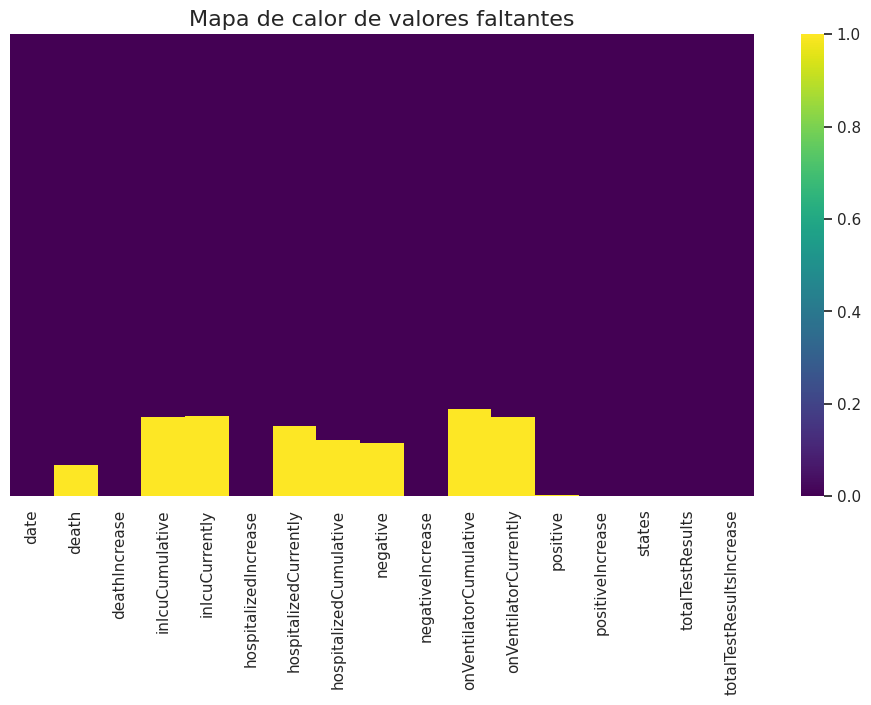

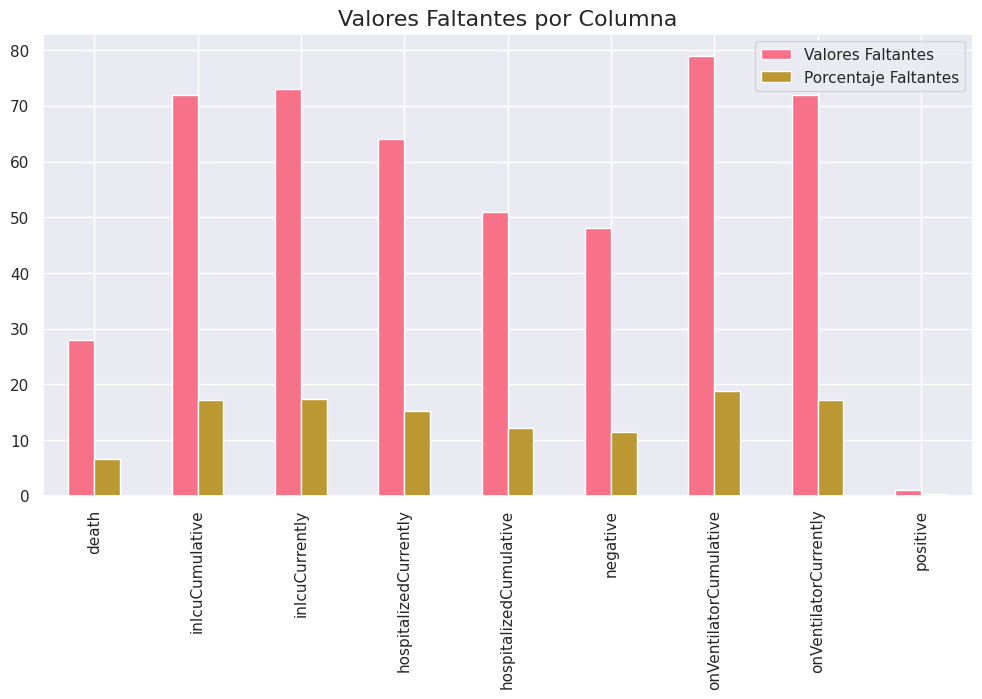


=== ANÁLISIS DE DEATH ===


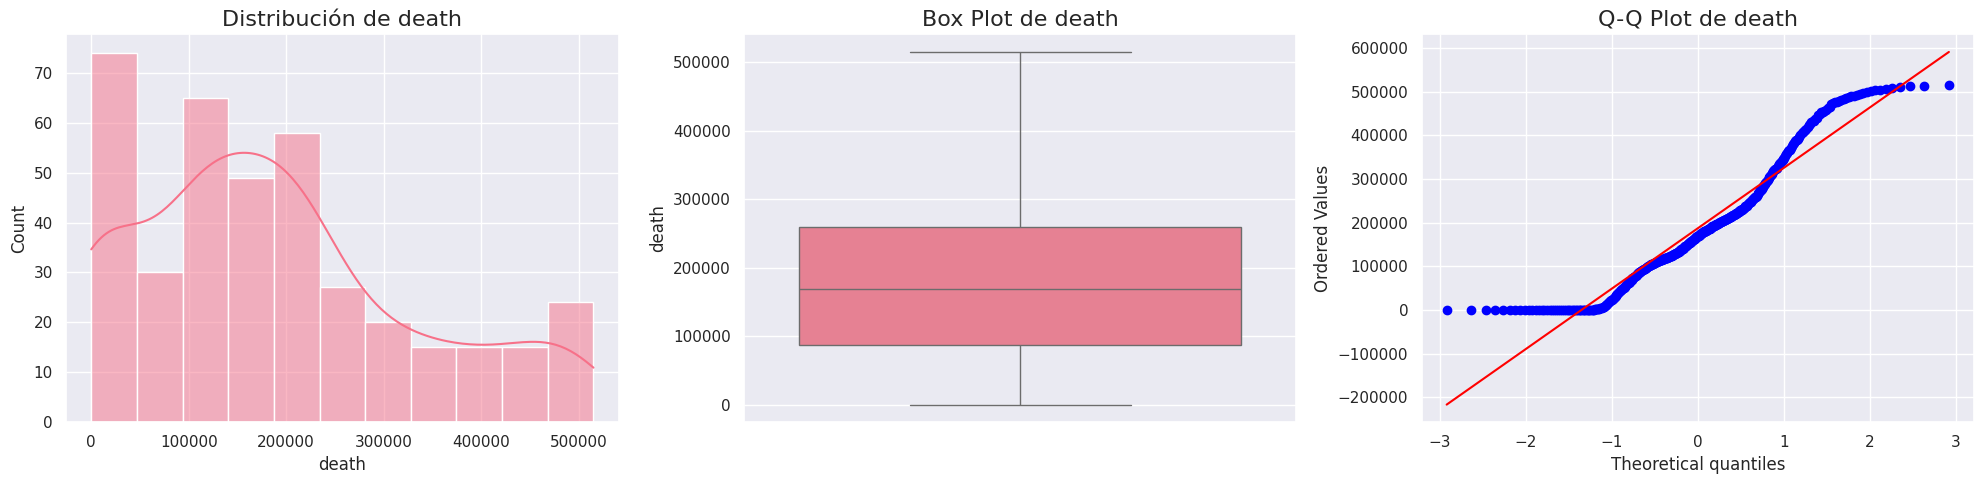


=== ANÁLISIS DE DEATHINCREASE ===


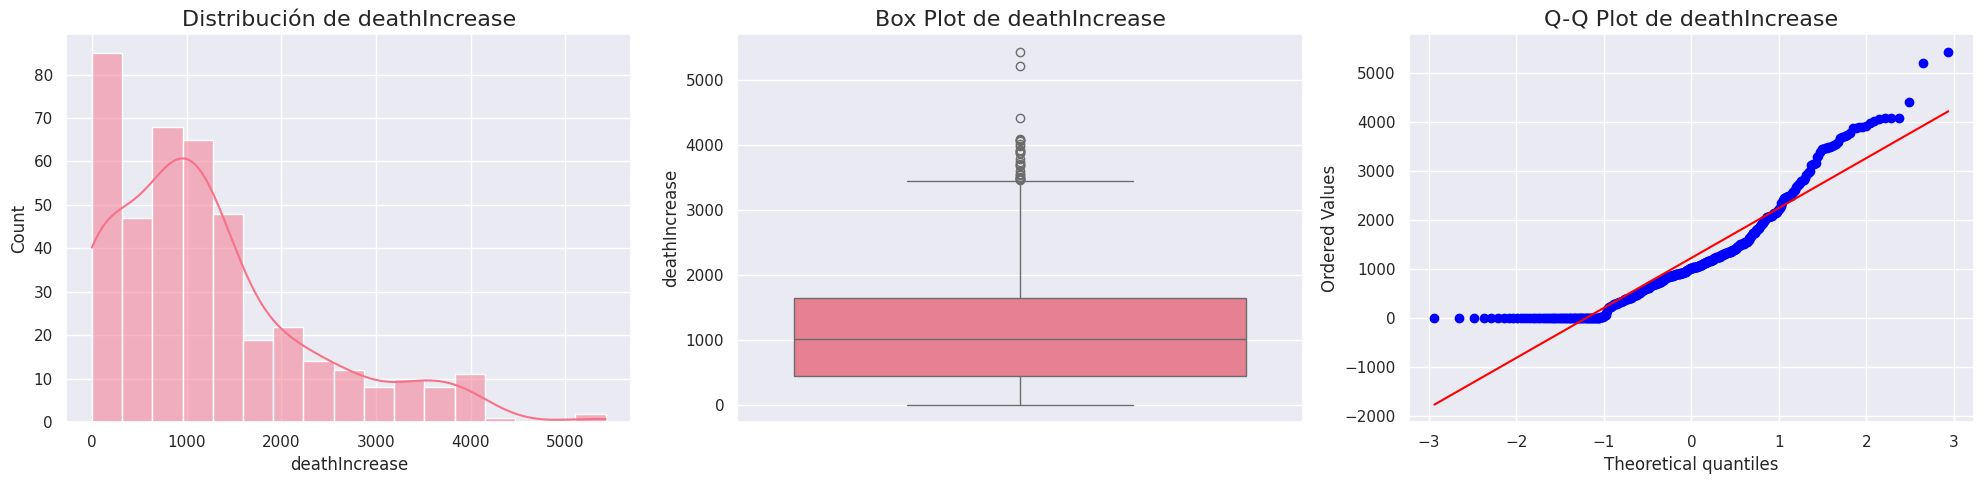


=== ANÁLISIS DE INICUCUMULATIVE ===


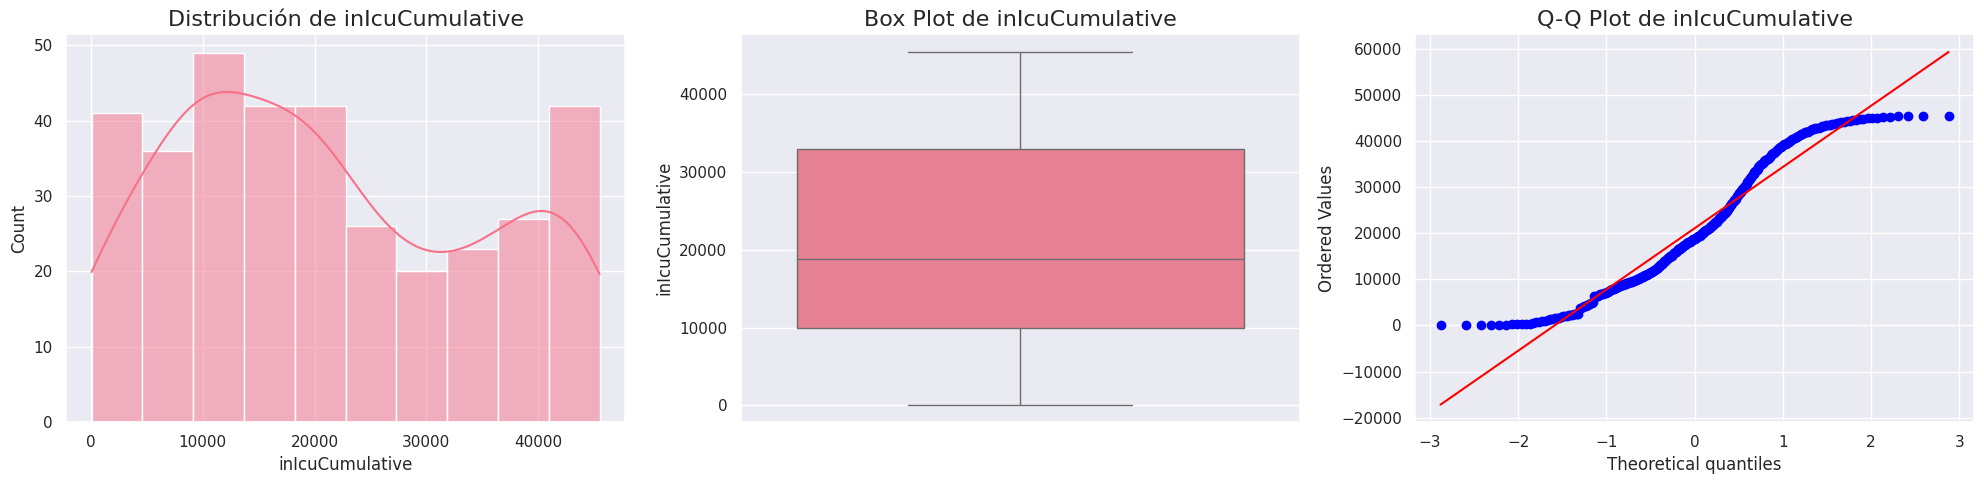


=== ANÁLISIS DE INICUCURRENTLY ===


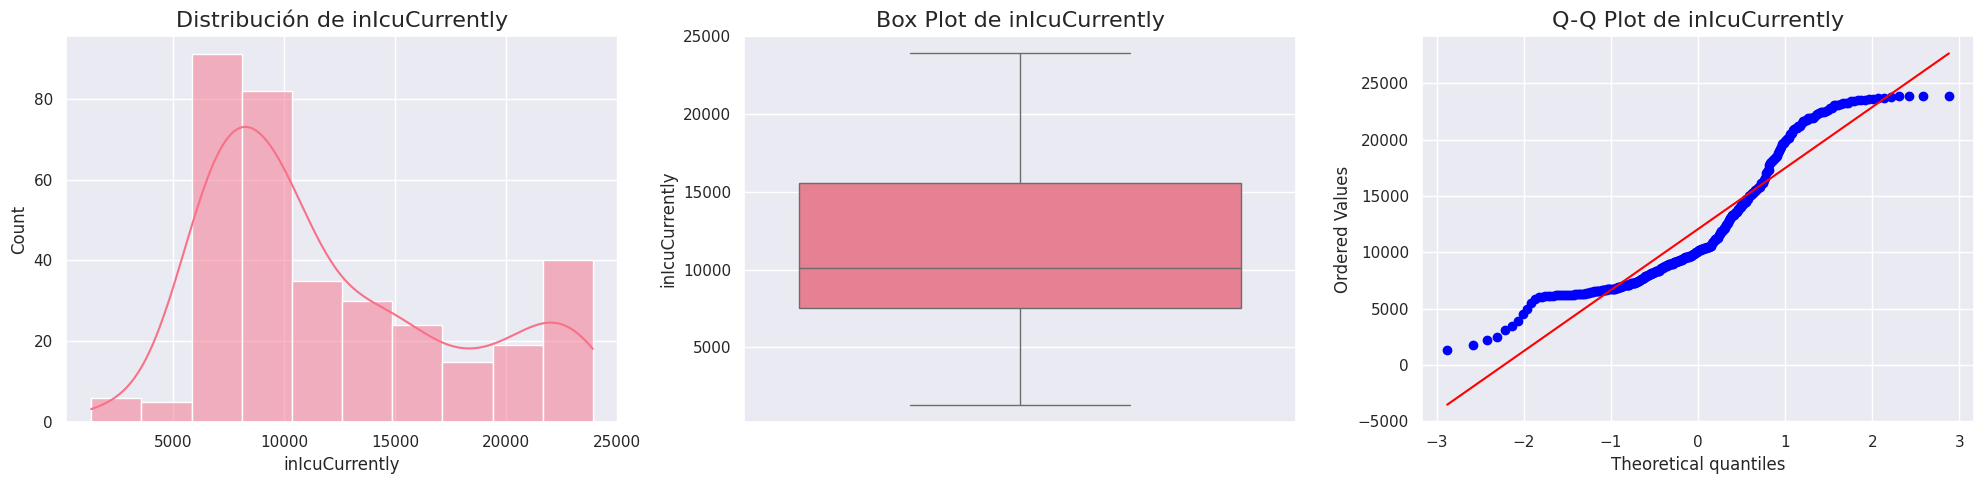


=== ANÁLISIS DE HOSPITALIZEDINCREASE ===


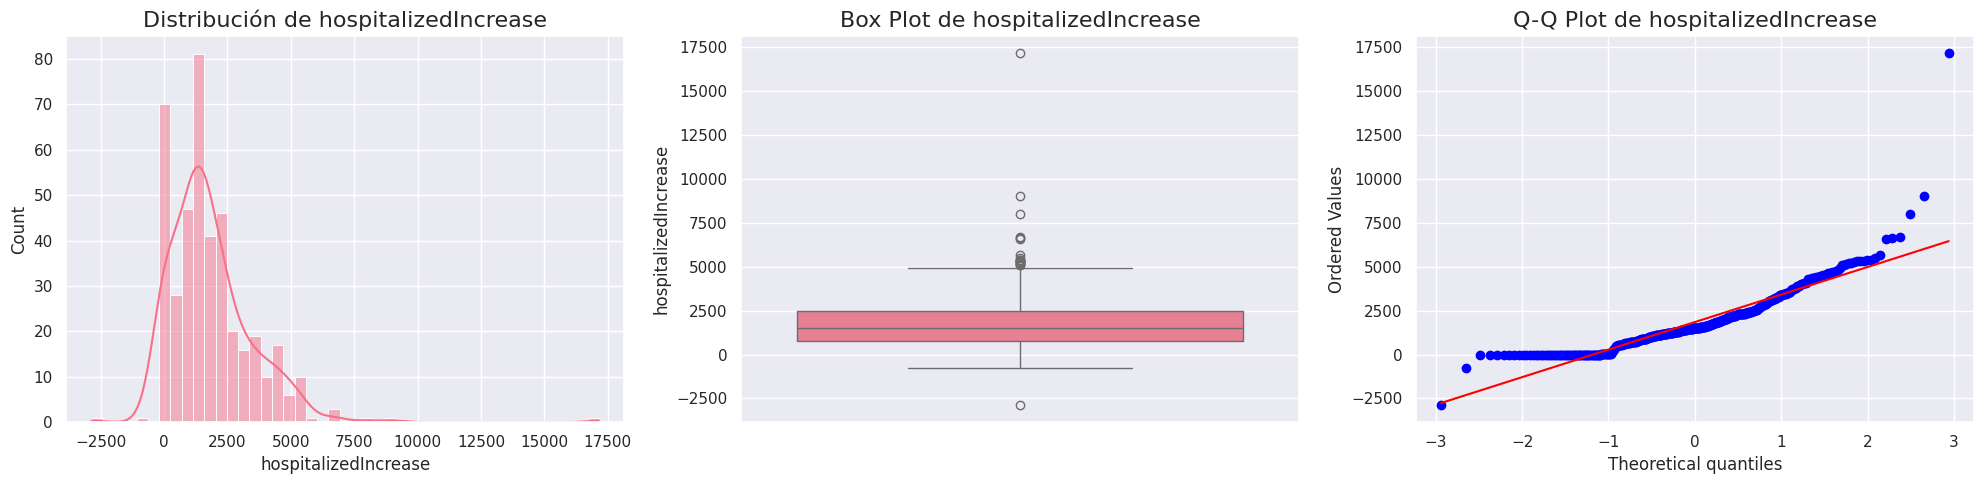


=== ANÁLISIS DE HOSPITALIZEDCURRENTLY ===


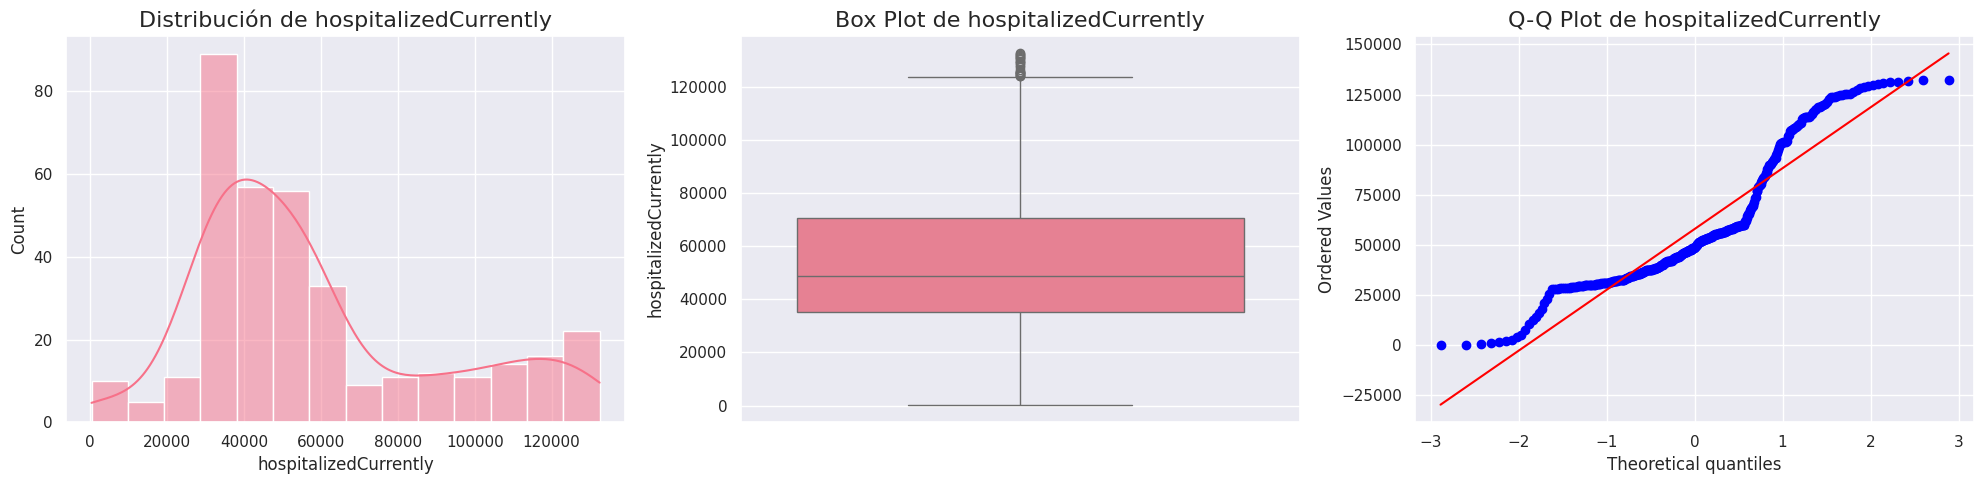


=== ANÁLISIS DE HOSPITALIZEDCUMULATIVE ===


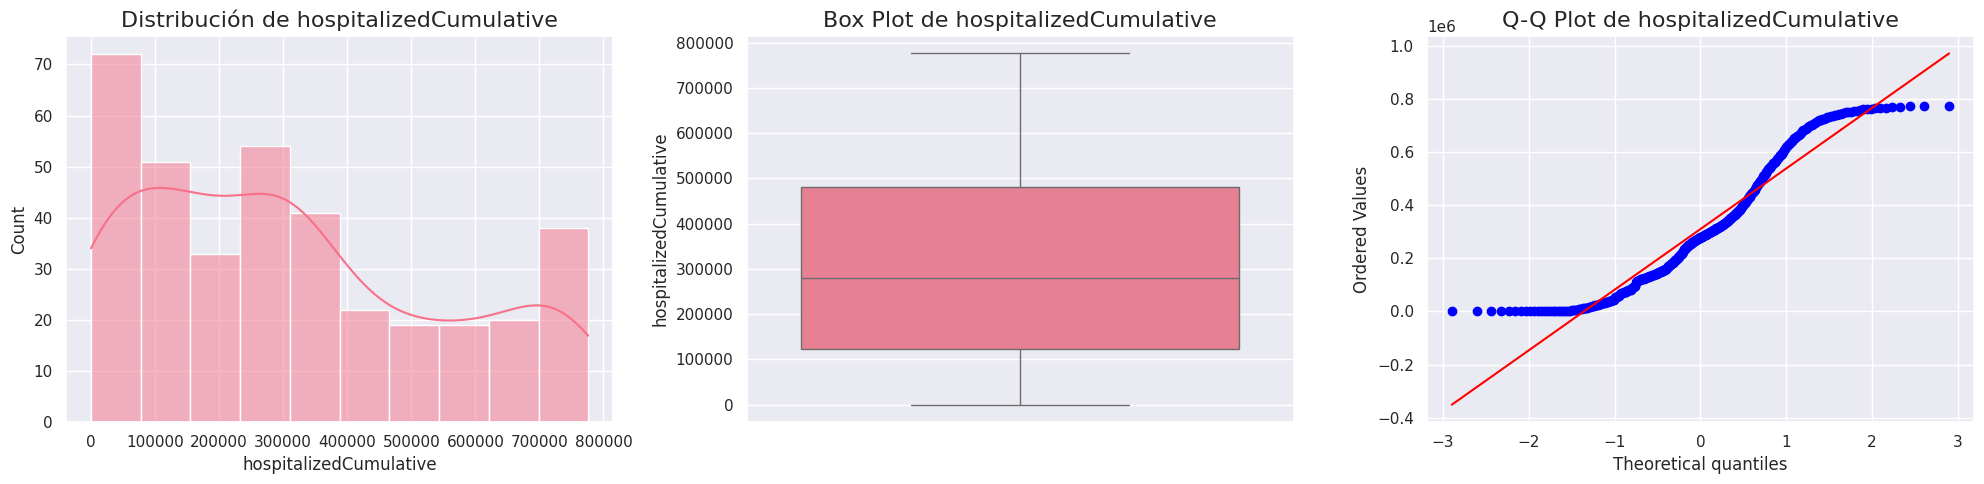


=== ANÁLISIS DE NEGATIVE ===


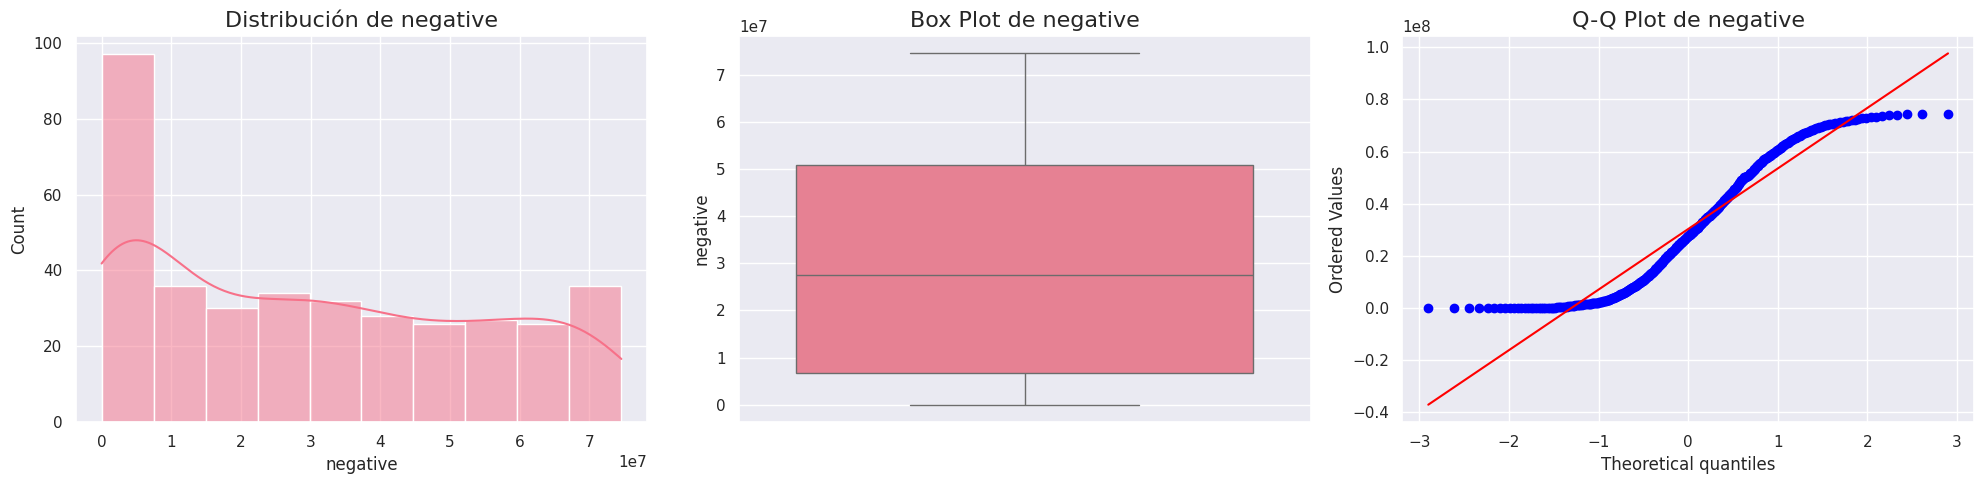


=== ANÁLISIS DE NEGATIVEINCREASE ===


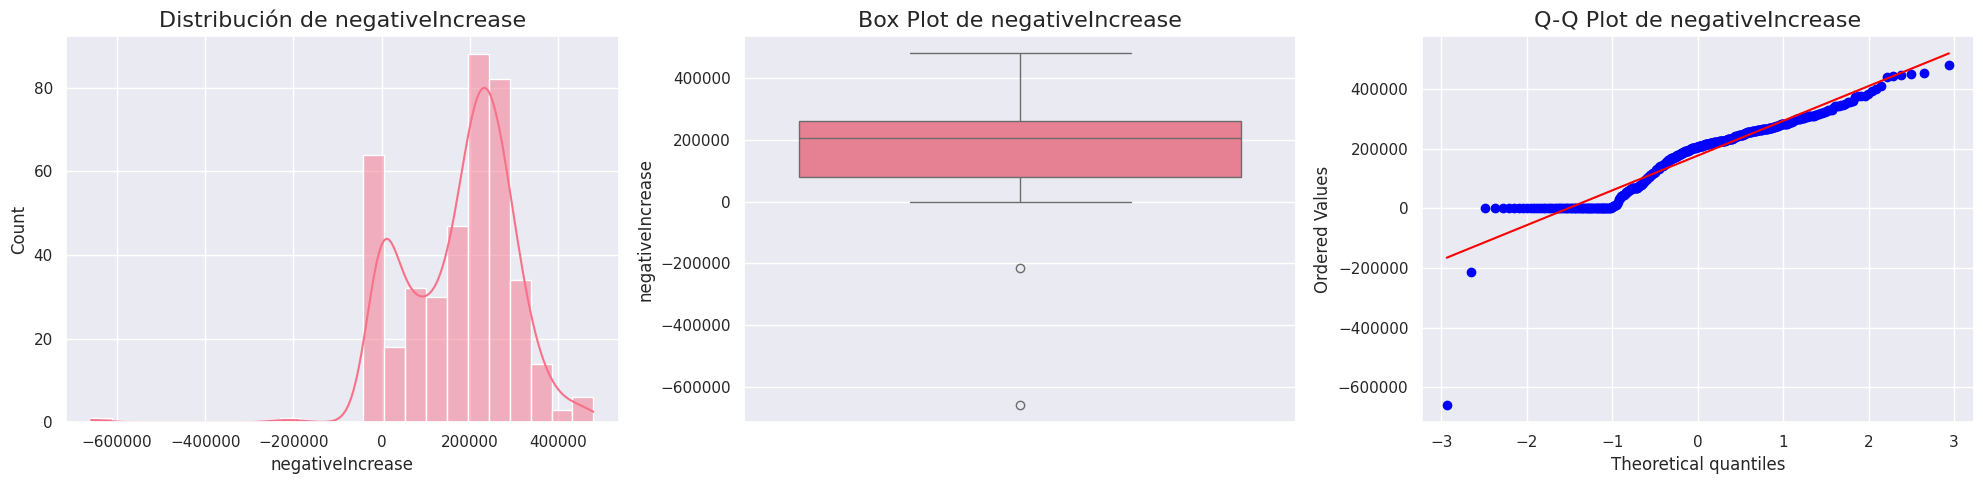


=== ANÁLISIS DE ONVENTILATORCUMULATIVE ===


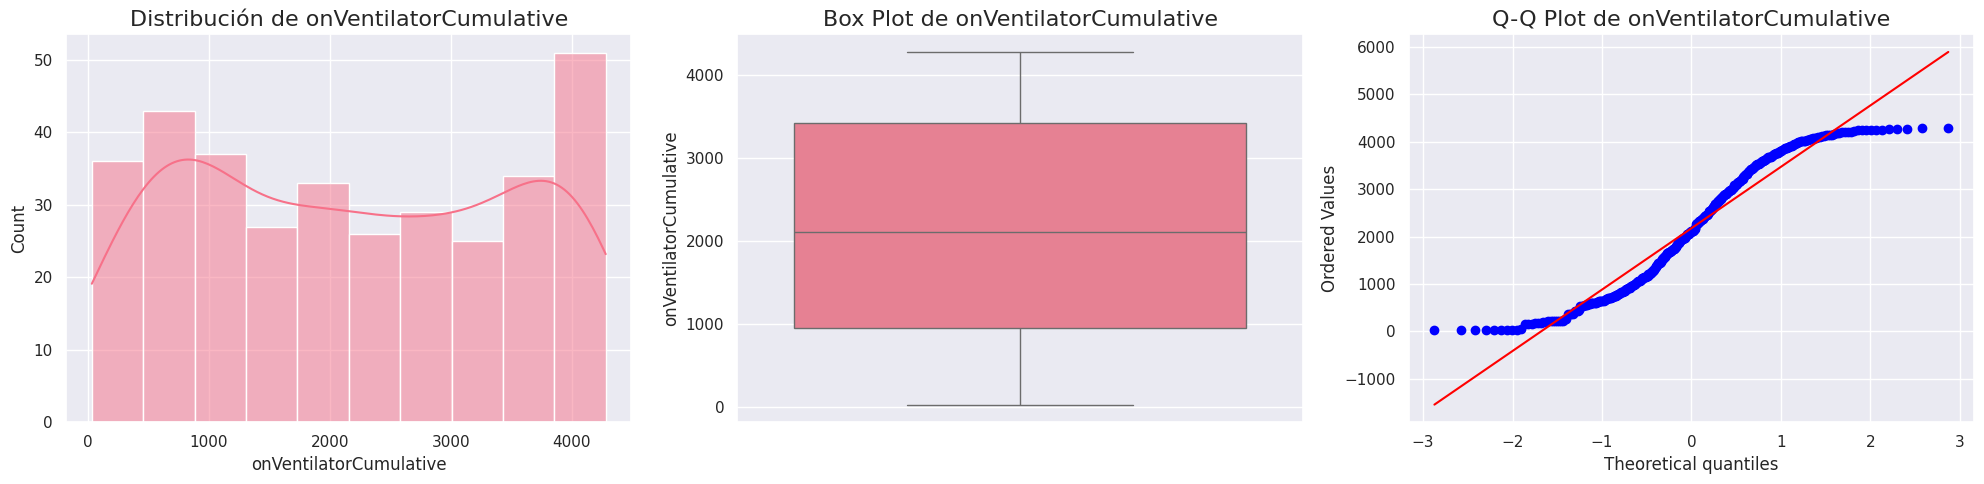


=== ANÁLISIS DE ONVENTILATORCURRENTLY ===


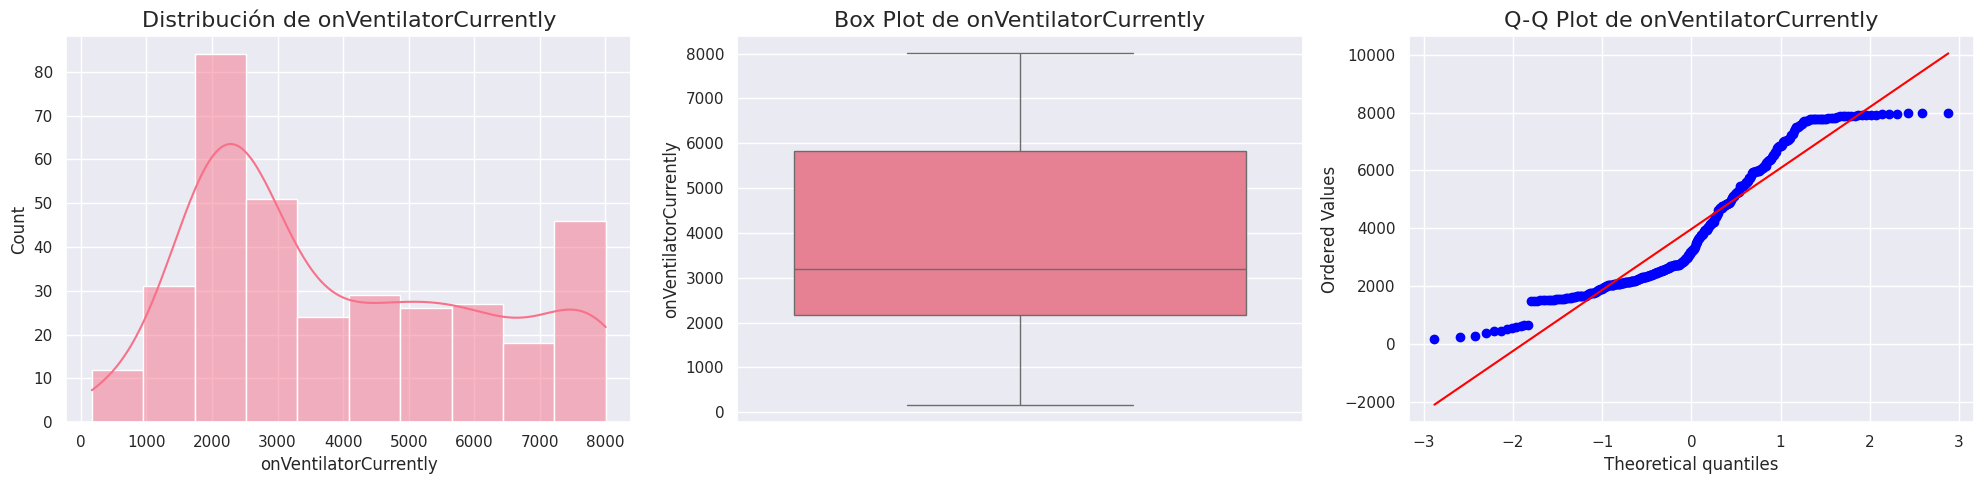


=== ANÁLISIS DE POSITIVE ===


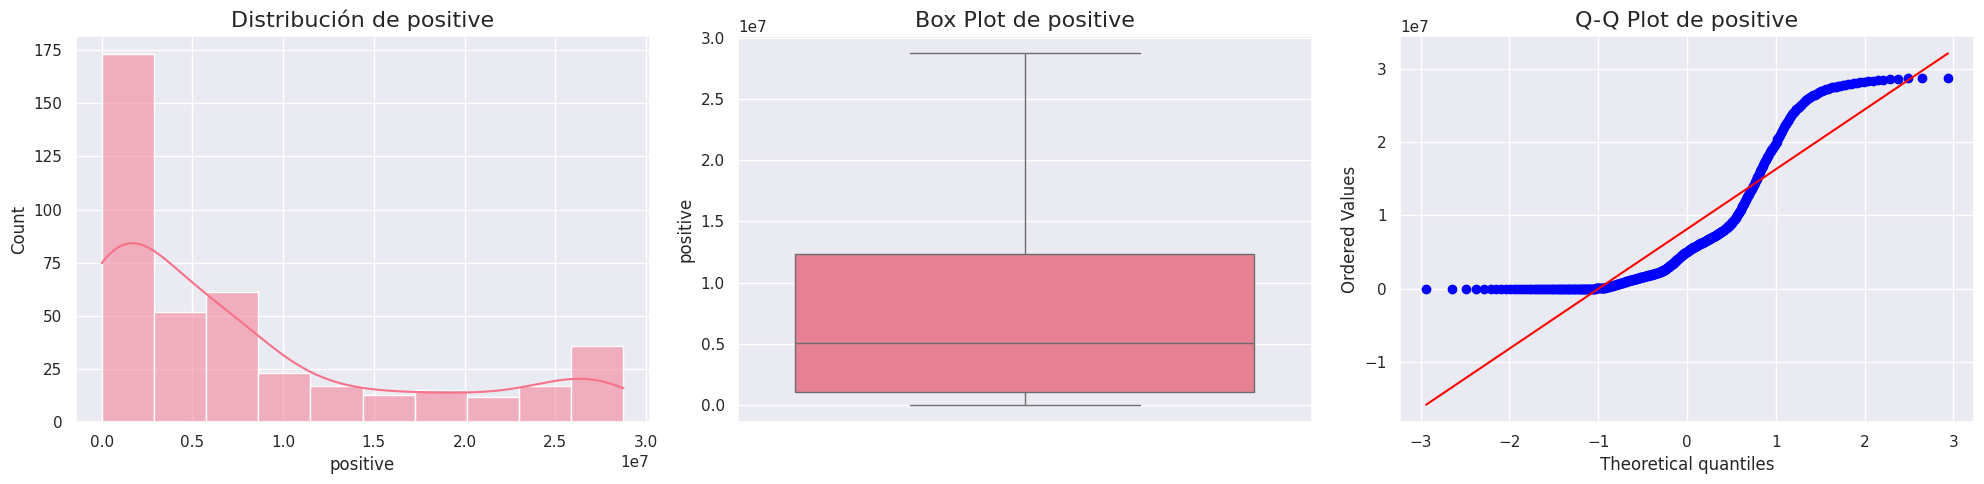


=== ANÁLISIS DE POSITIVEINCREASE ===


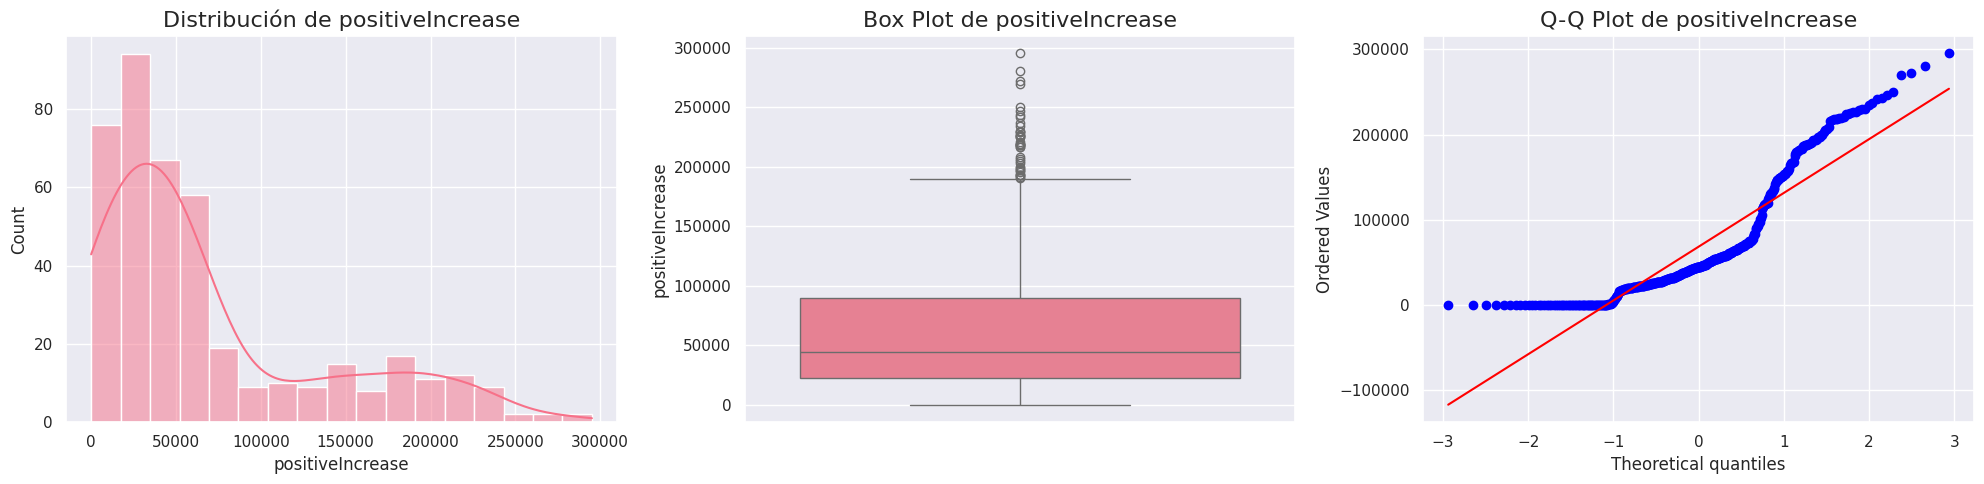


=== ANÁLISIS DE STATES ===


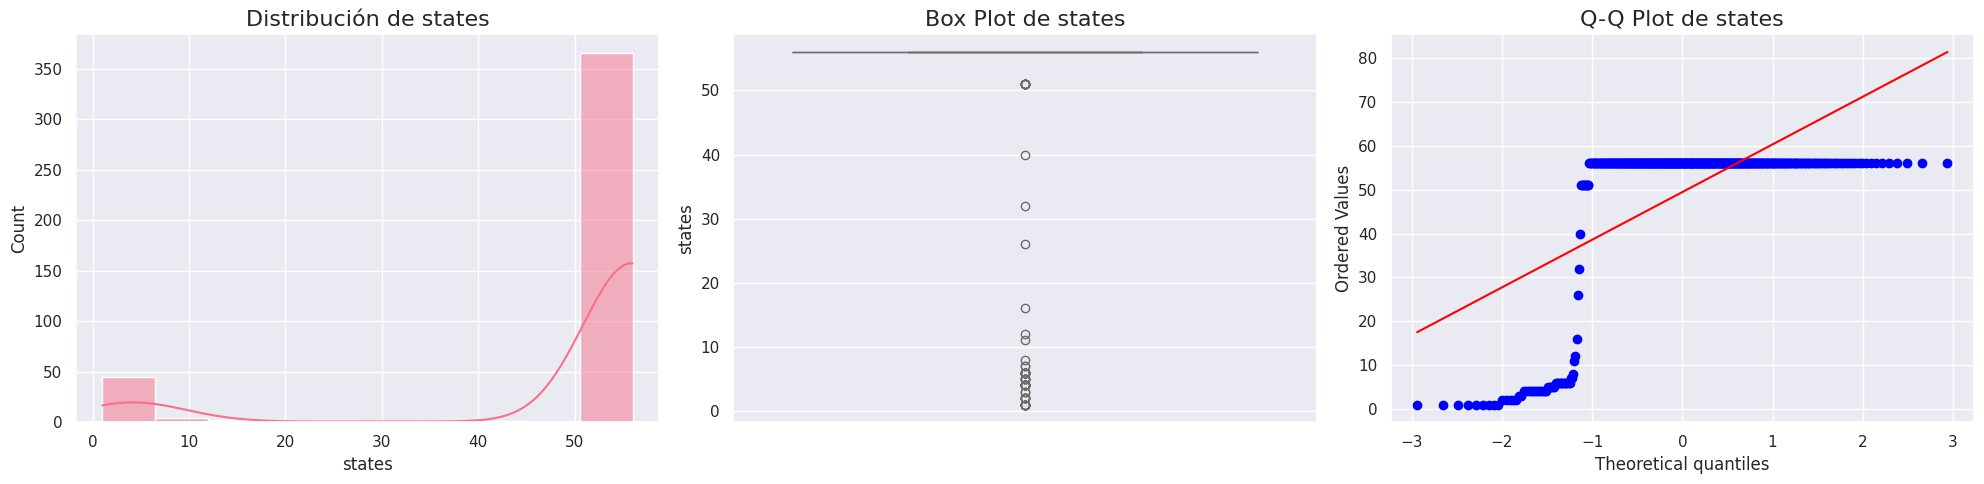


=== ANÁLISIS DE TOTALTESTRESULTS ===


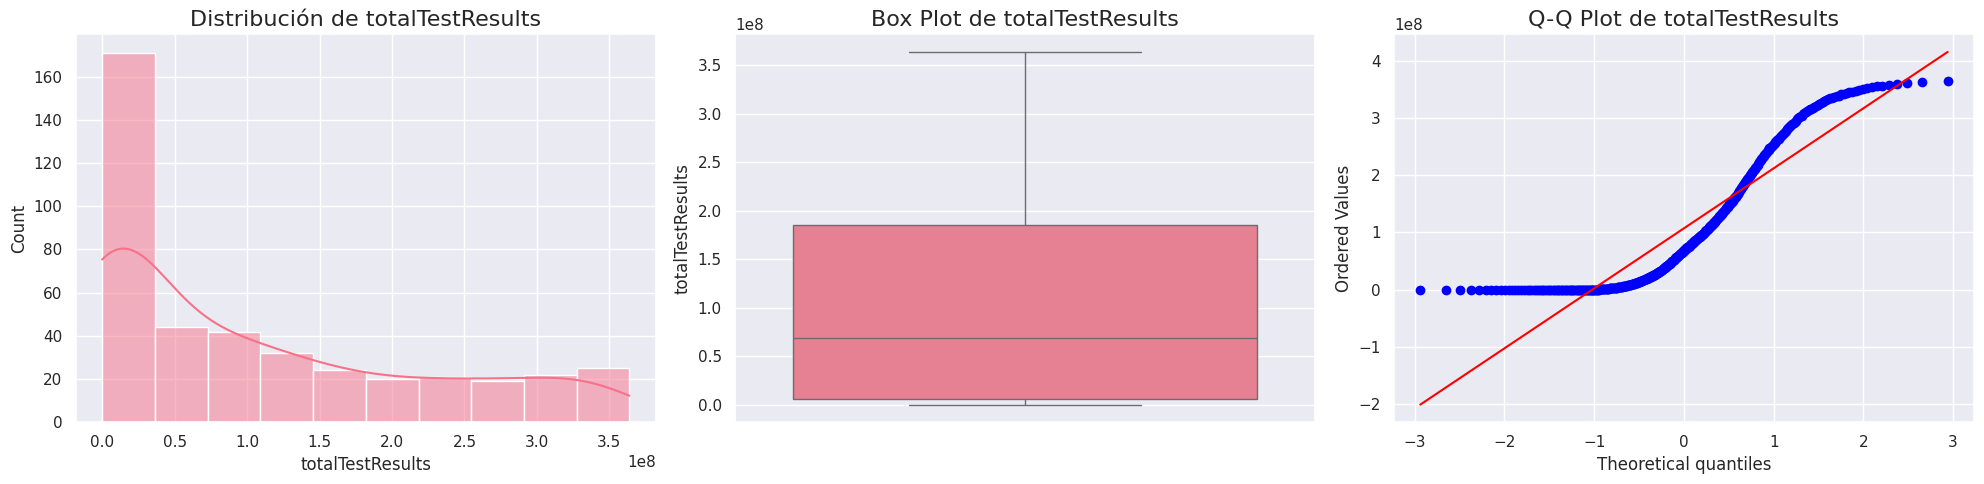


=== ANÁLISIS DE TOTALTESTRESULTSINCREASE ===


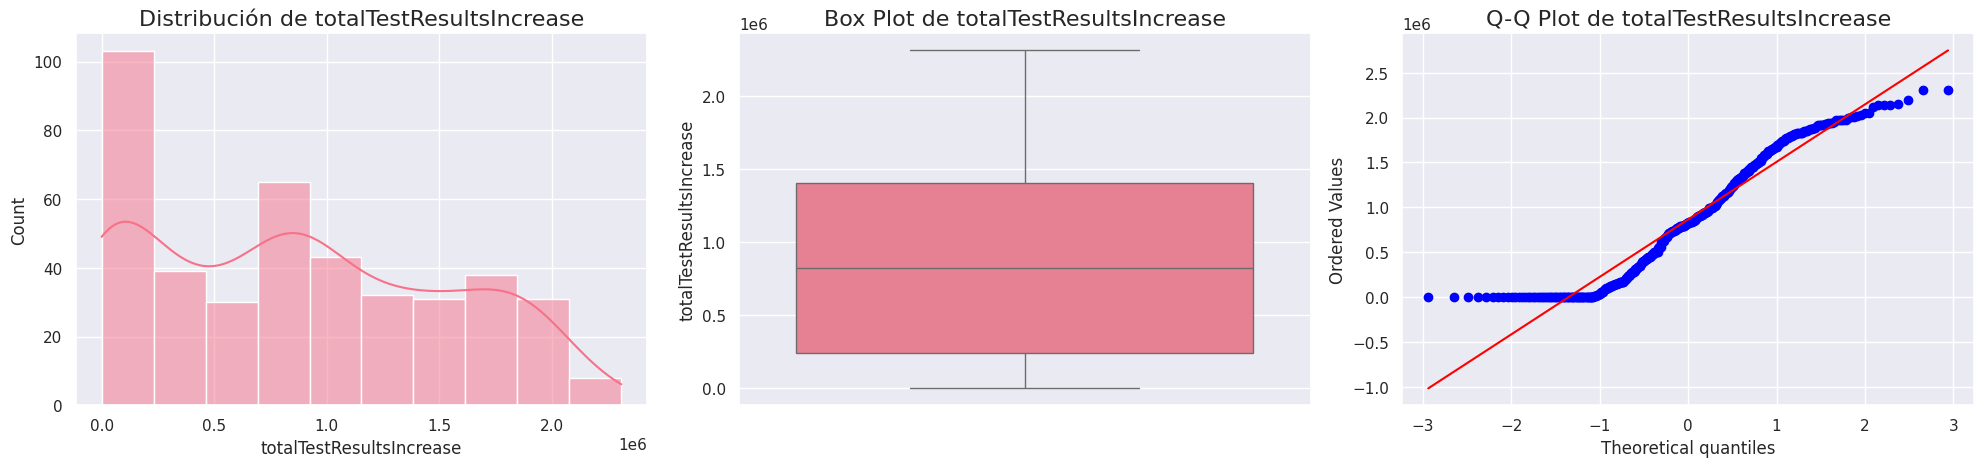

=== ANÁLISIS DE VARIABLES CATEGÓRICAS ===

=== Distribución de la variable DATE ===


Frecuencia  Porcentaje
date                              
2020-01-13           1        0.24
2021-03-07           1        0.24
2021-03-06           1        0.24
2021-03-05           1        0.24
2020-01-29           1        0.24
...                ...         ...
2021-02-27           1        0.24
2021-02-28           1        0.24
2021-03-01           1        0.24
2021-03-02           1        0.24
2021-03-03           1        0.24

[420 rows x 2 columns]

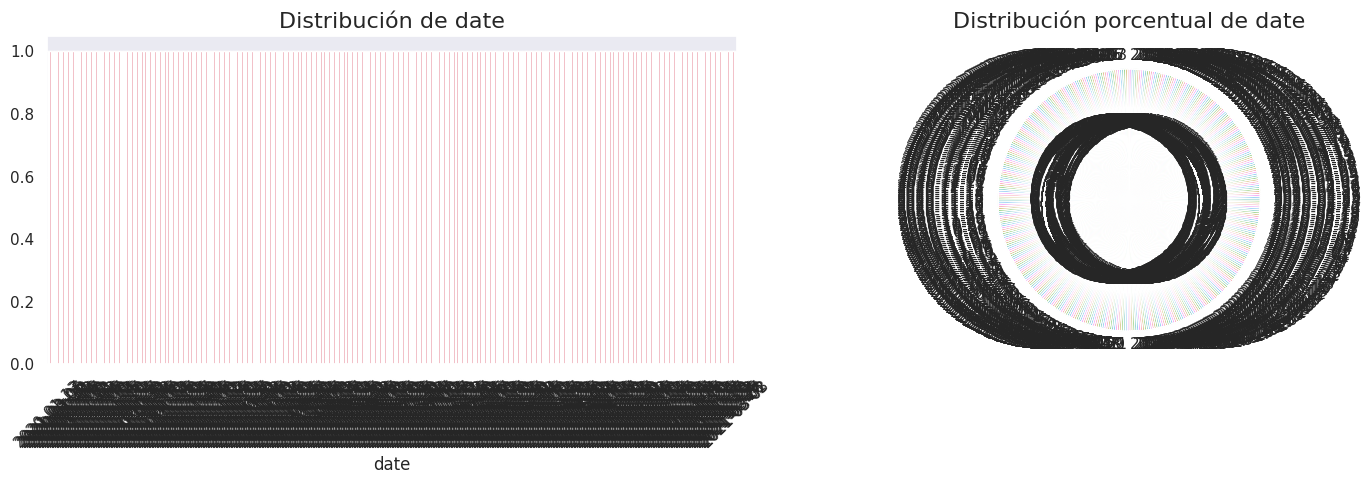

=== ANÁLISIS DE CORRELACIONES ===



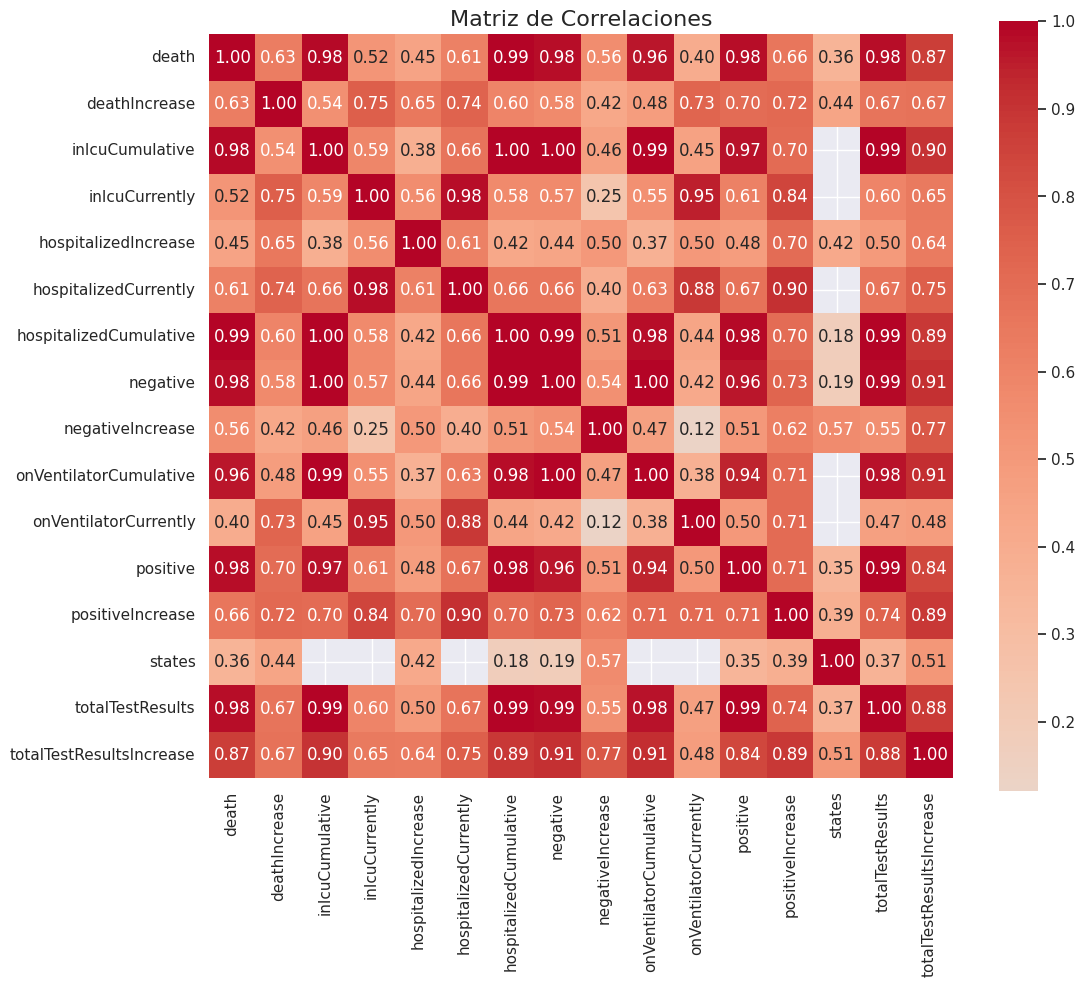

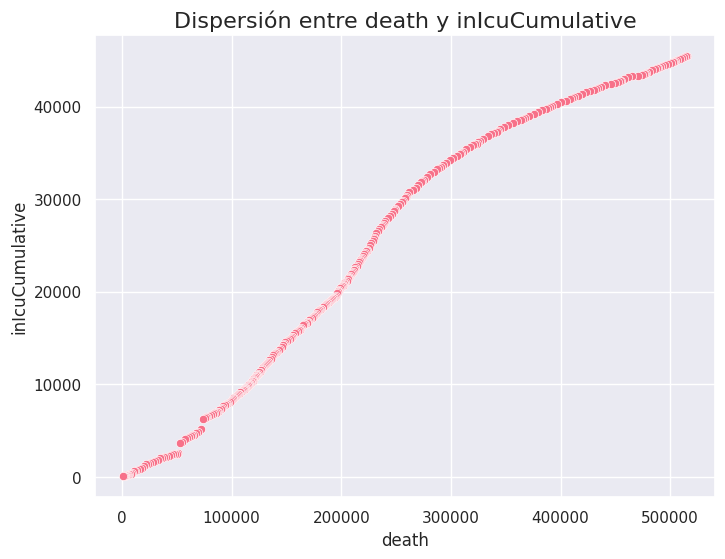

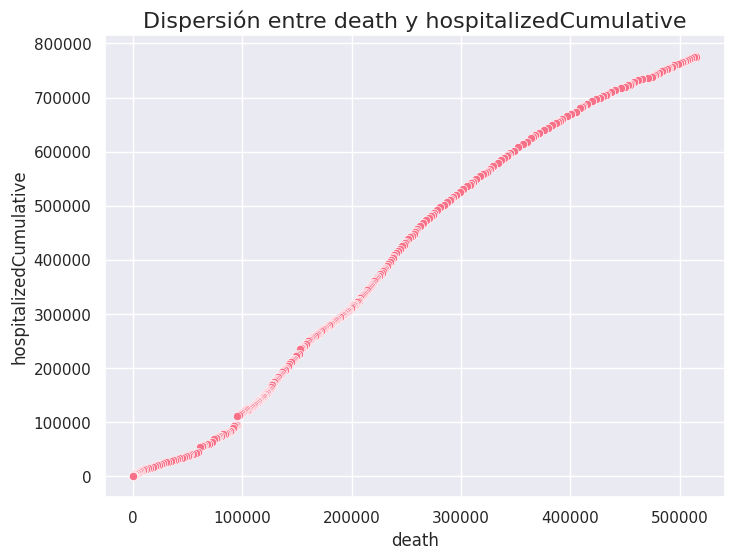

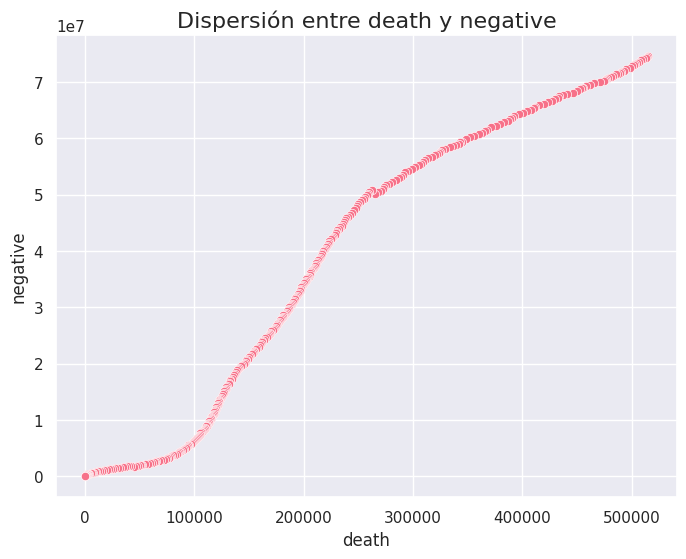

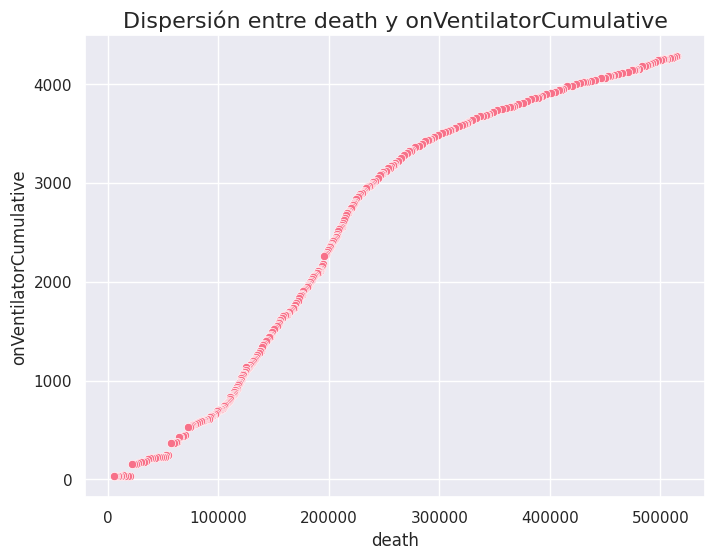

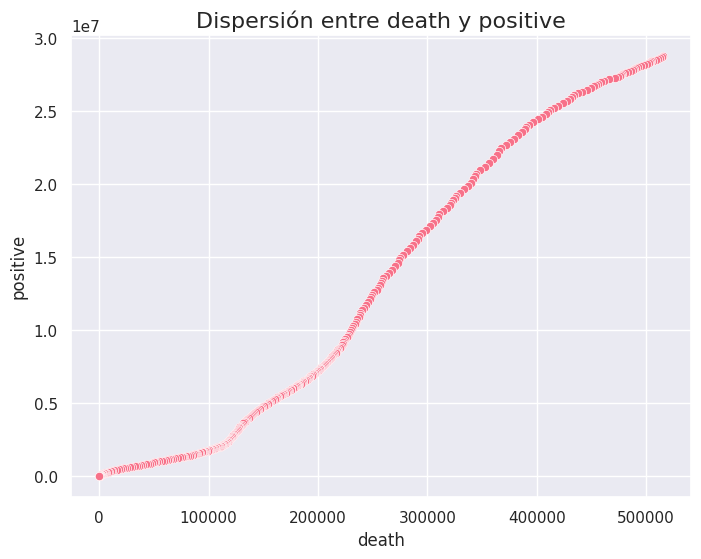

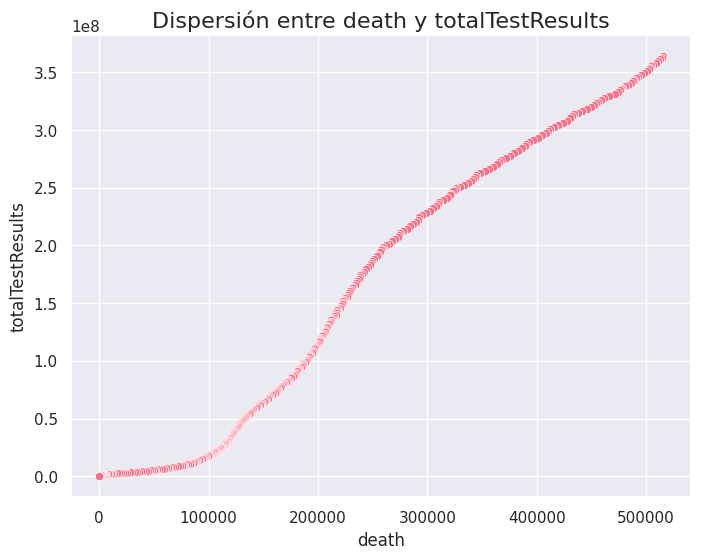

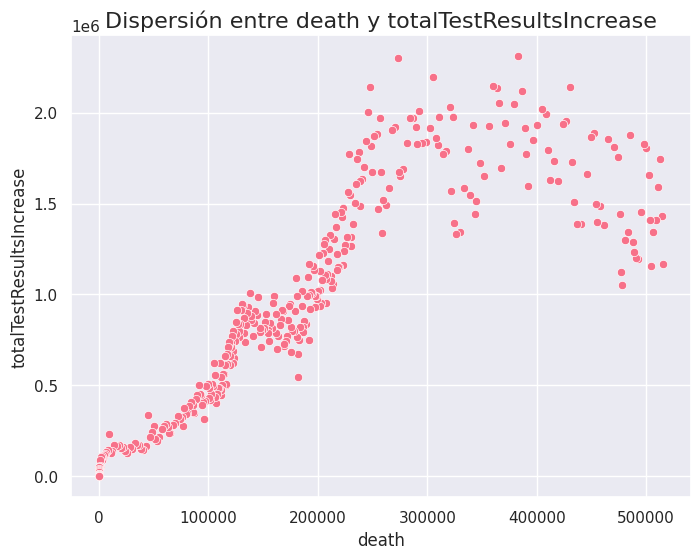

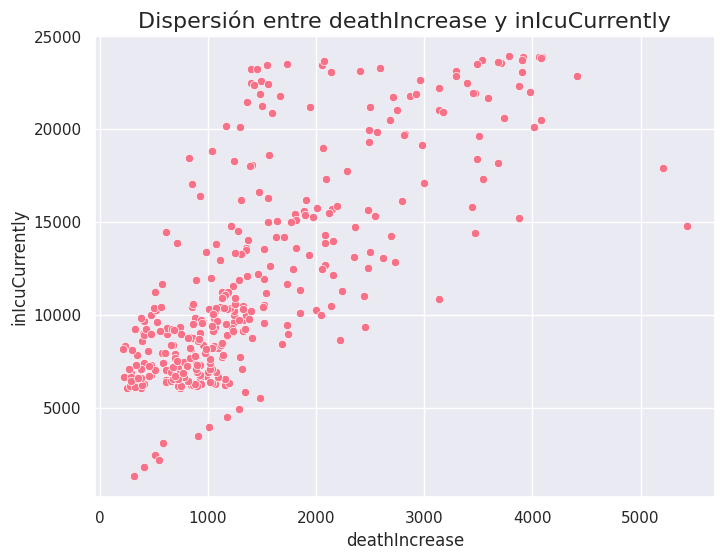

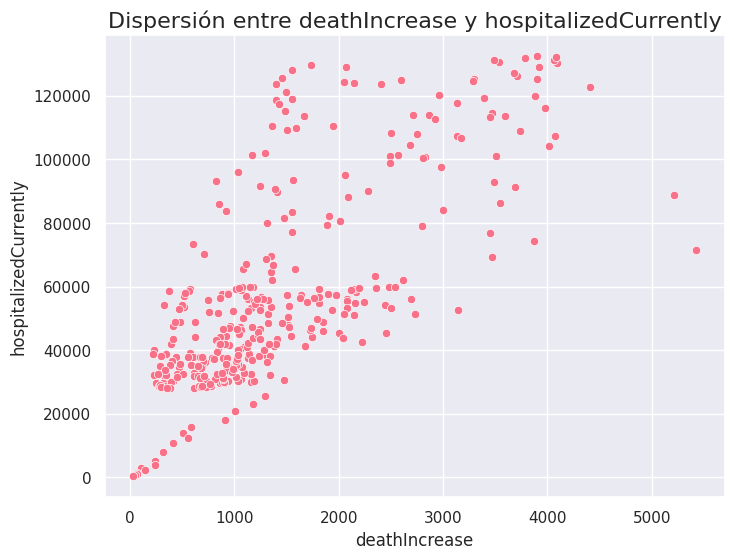

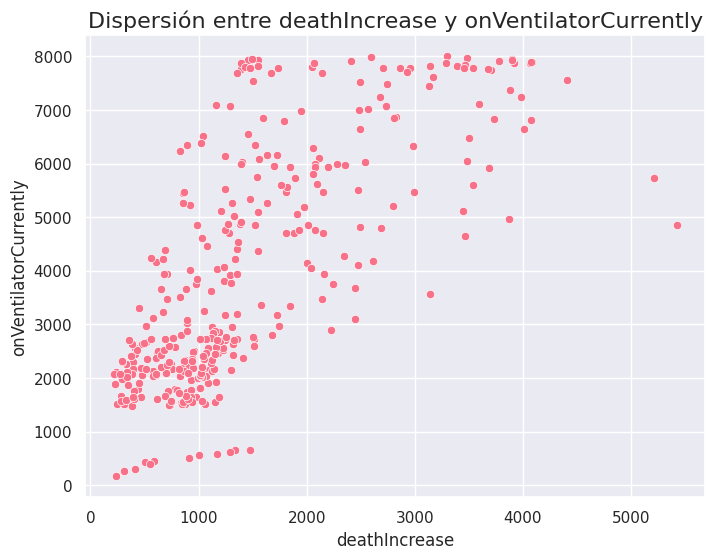

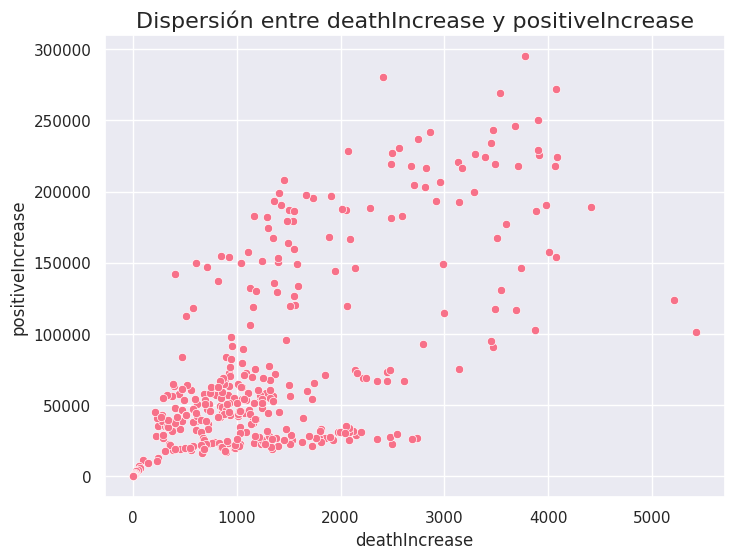

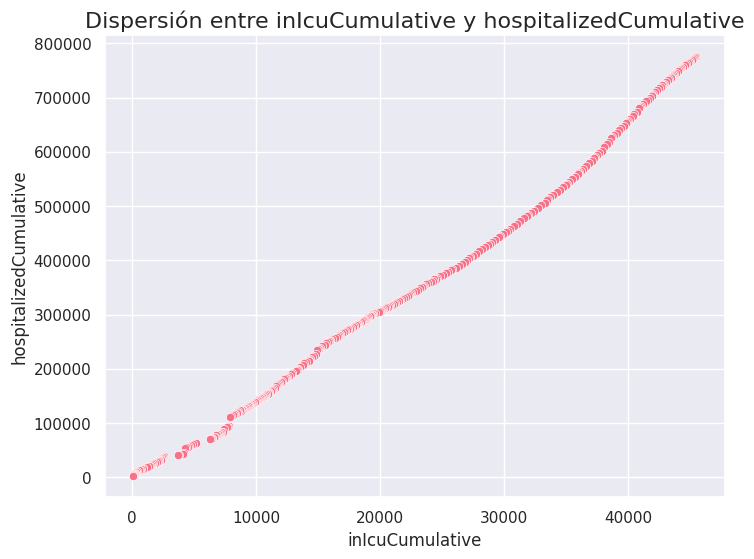

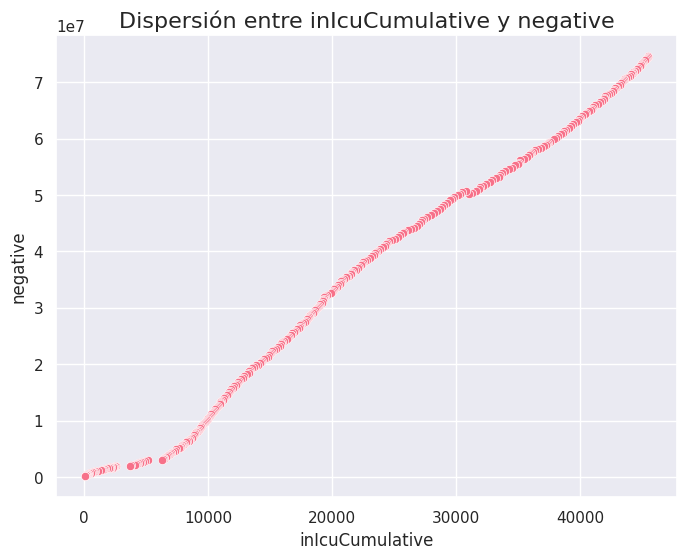

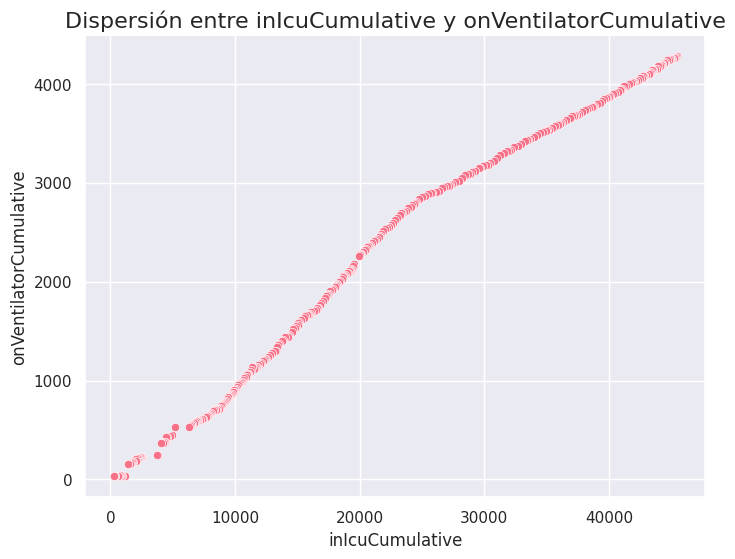

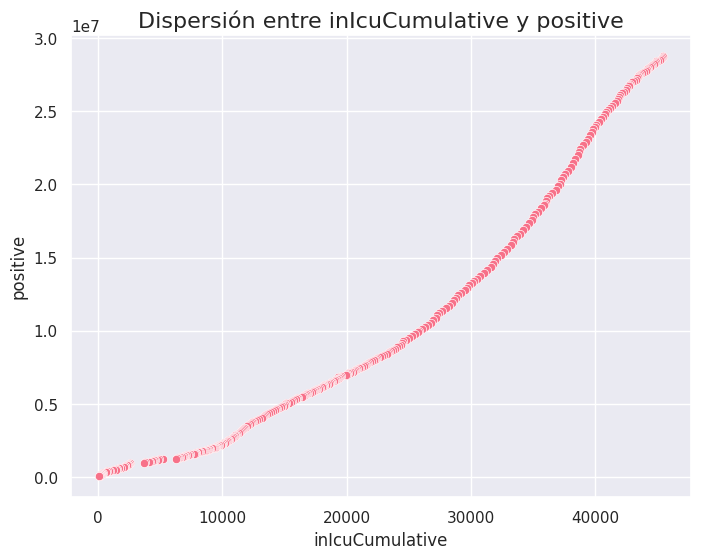

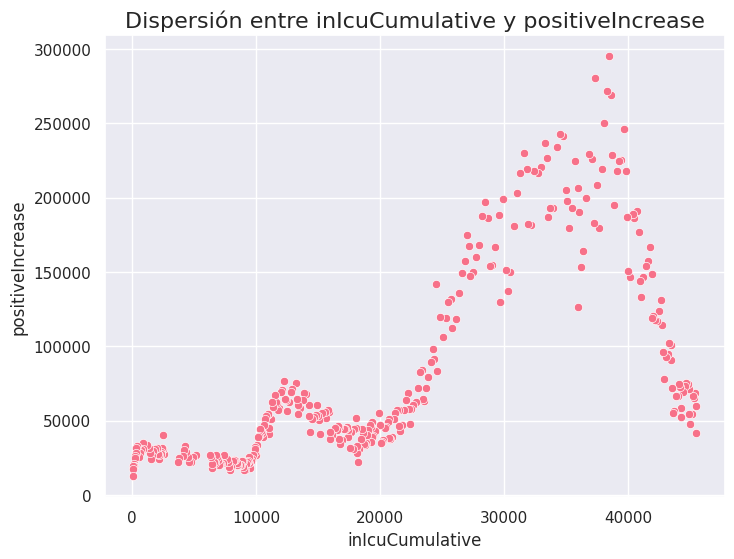

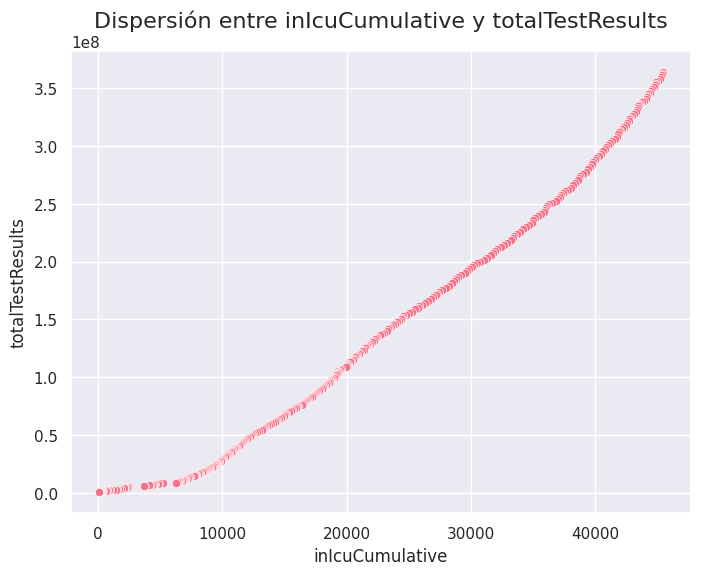

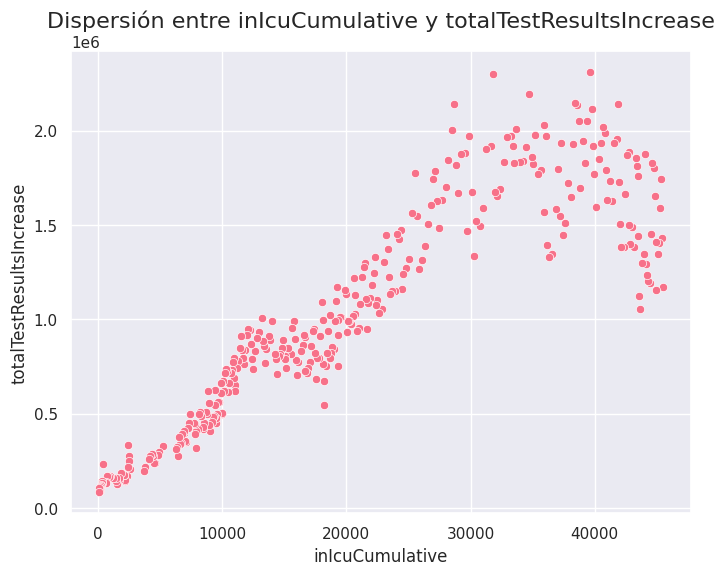

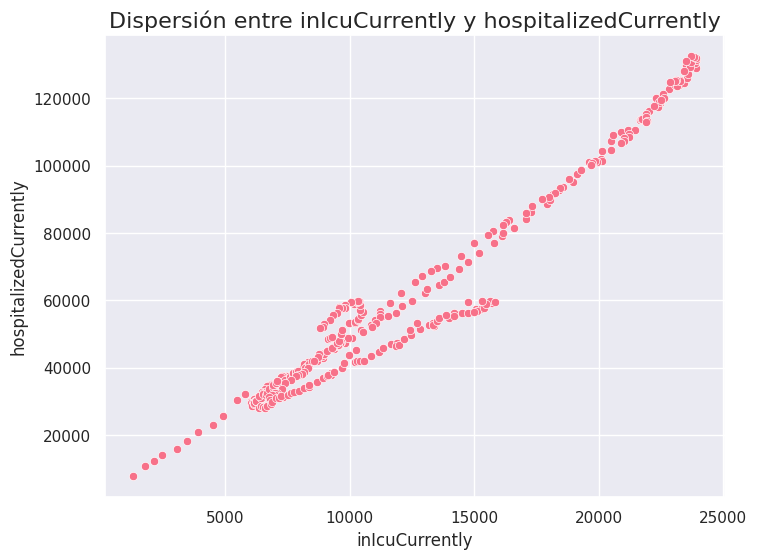

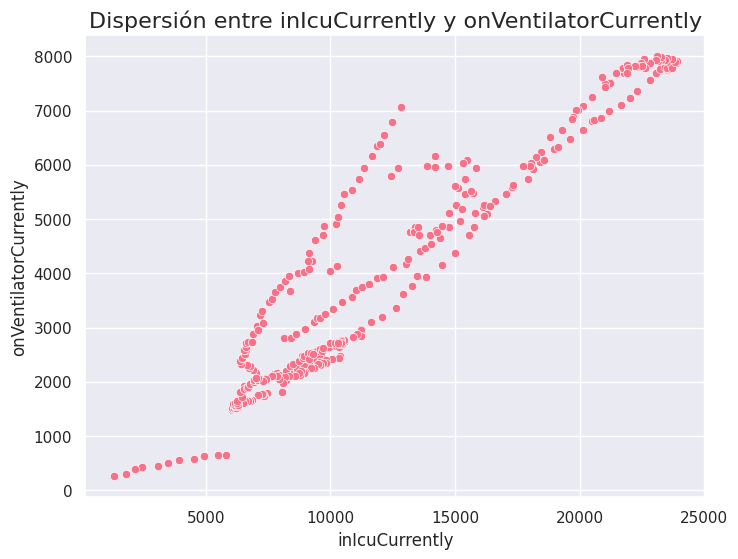

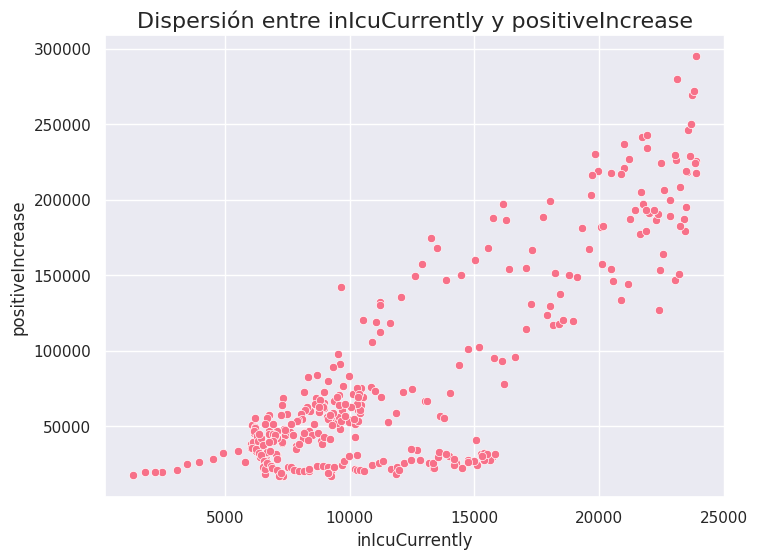

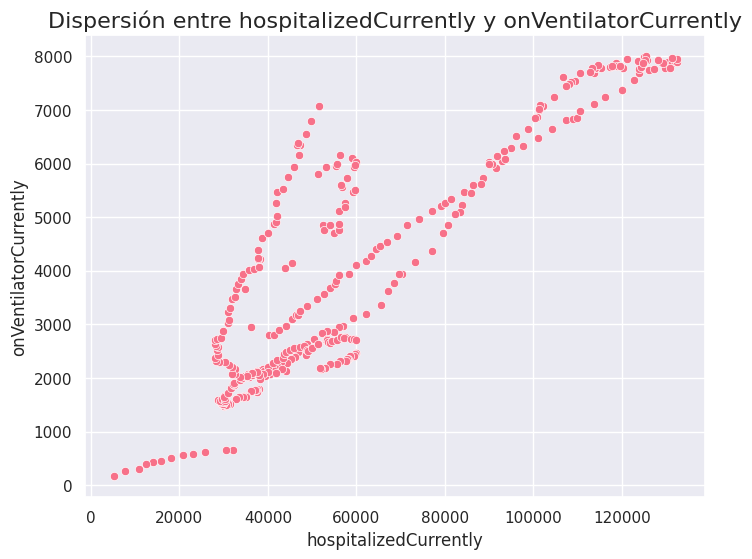

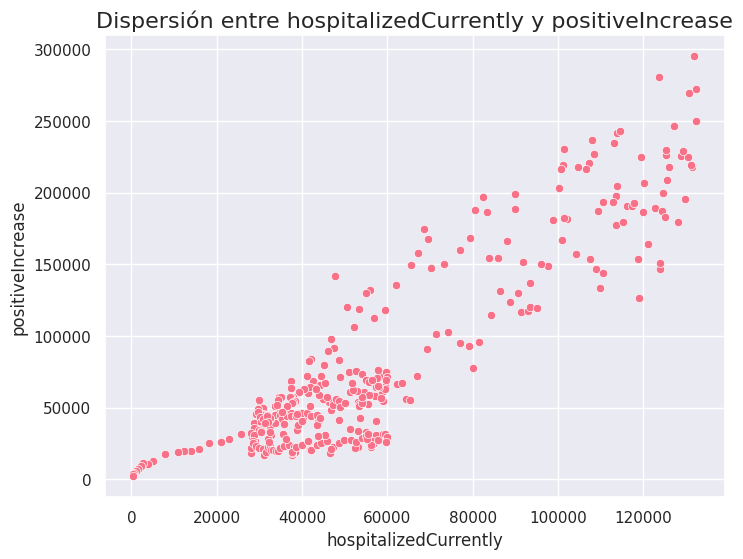

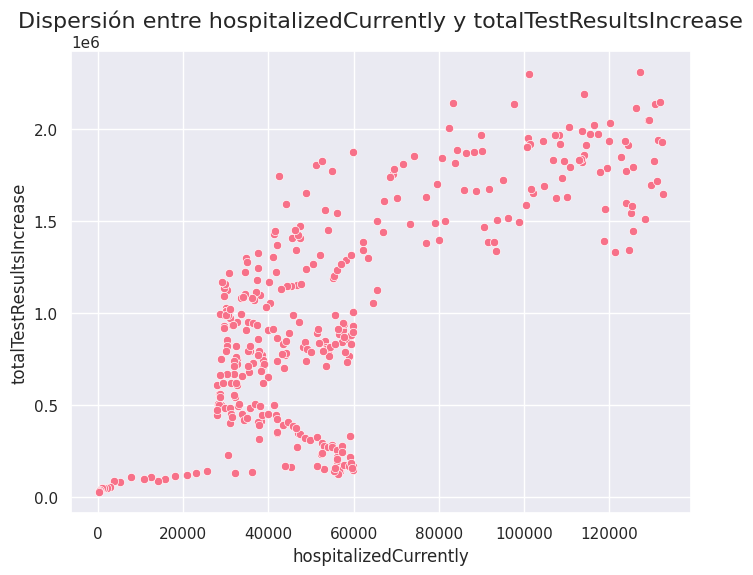

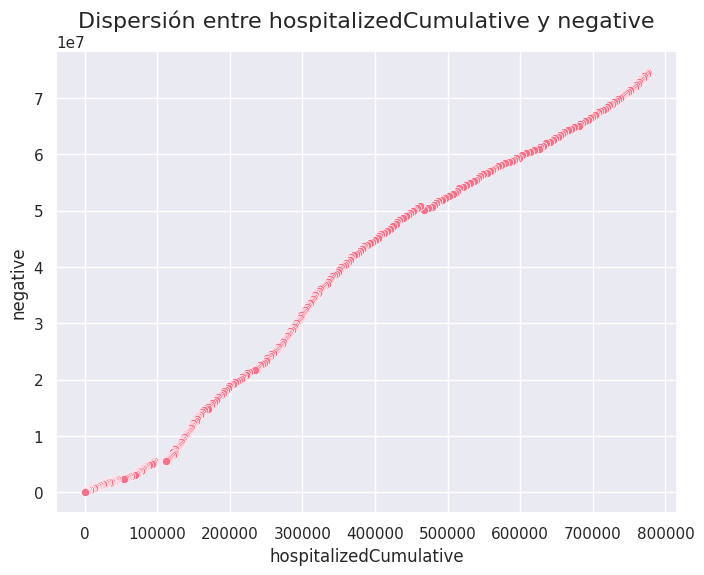

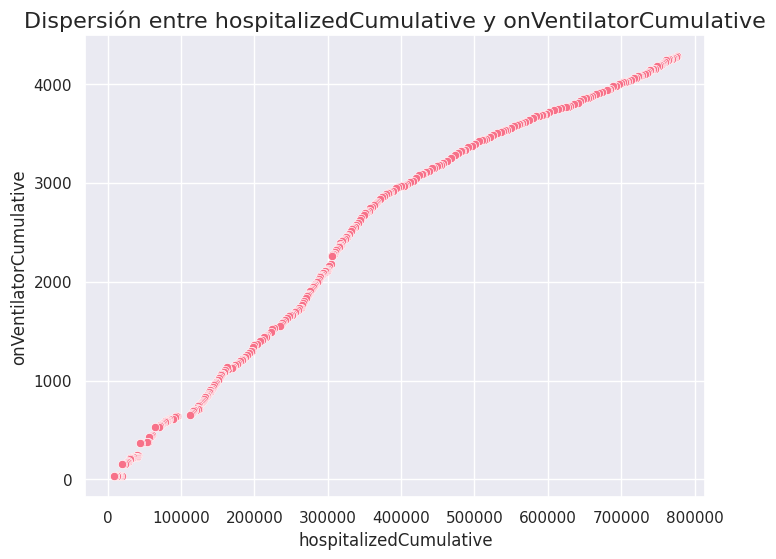

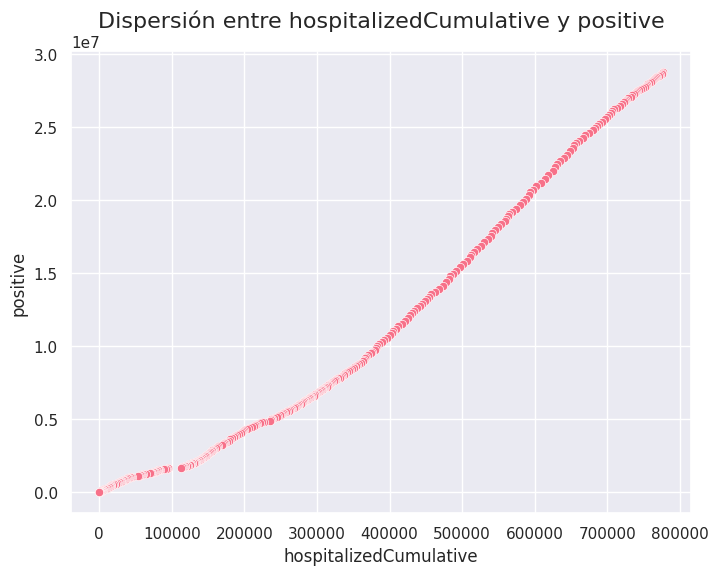

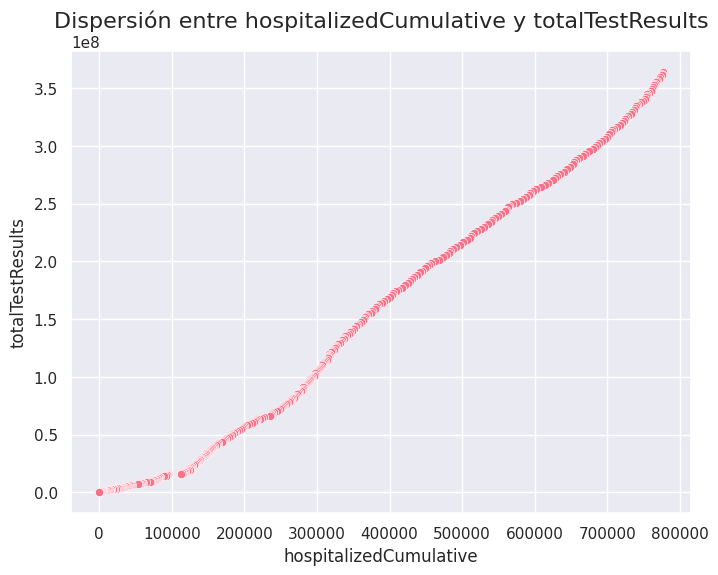

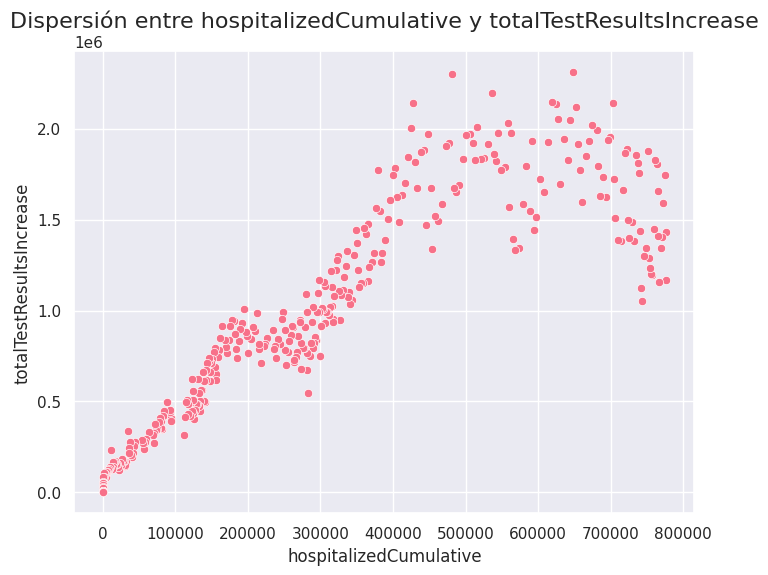

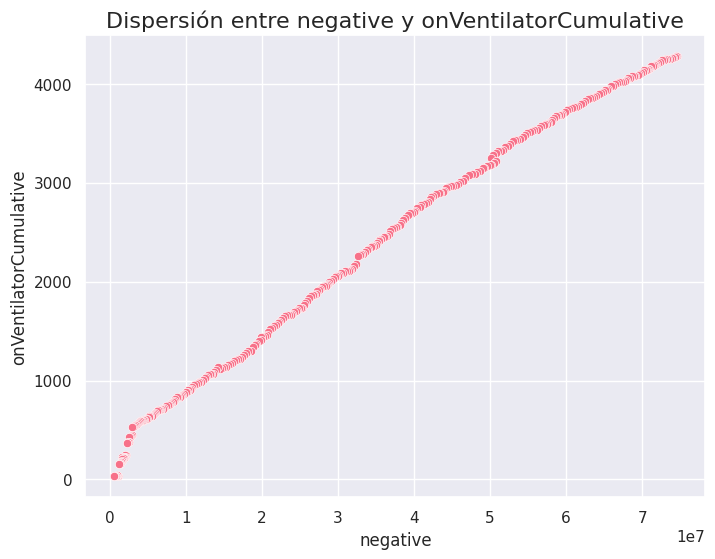

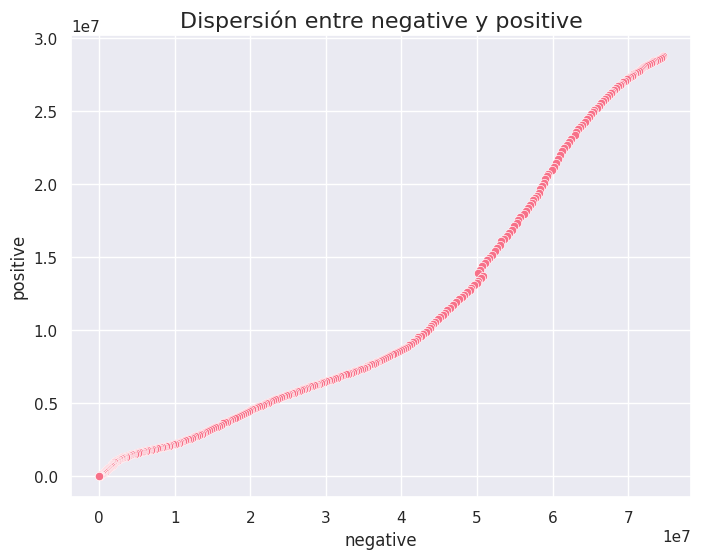

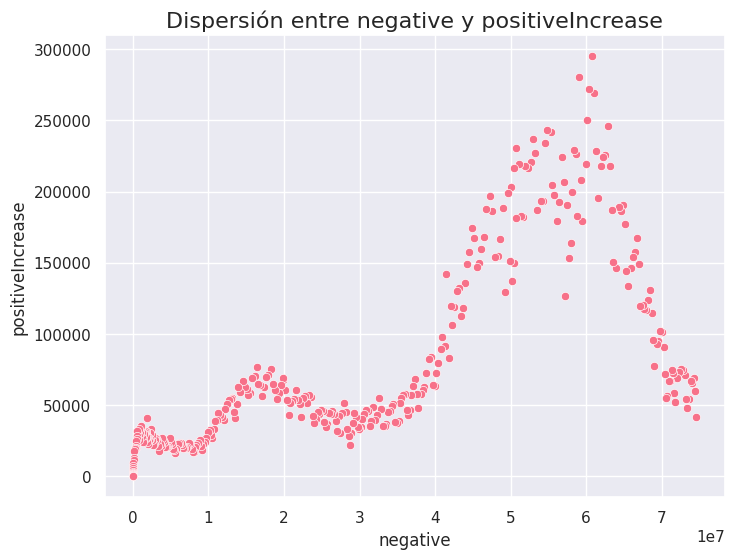

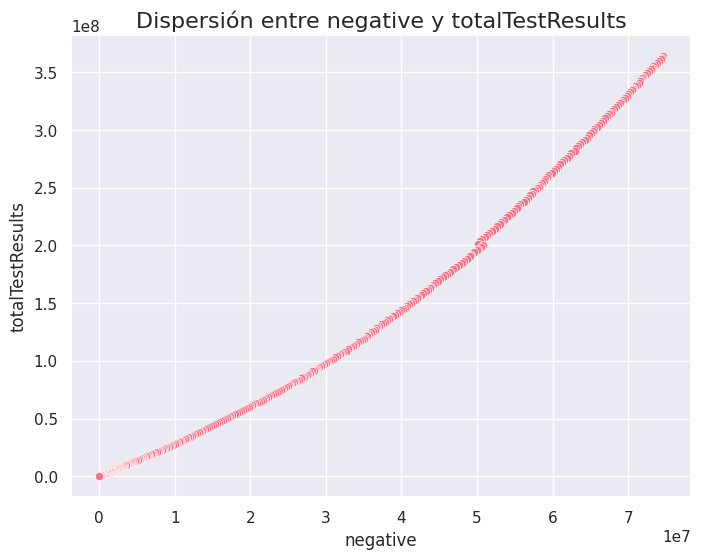

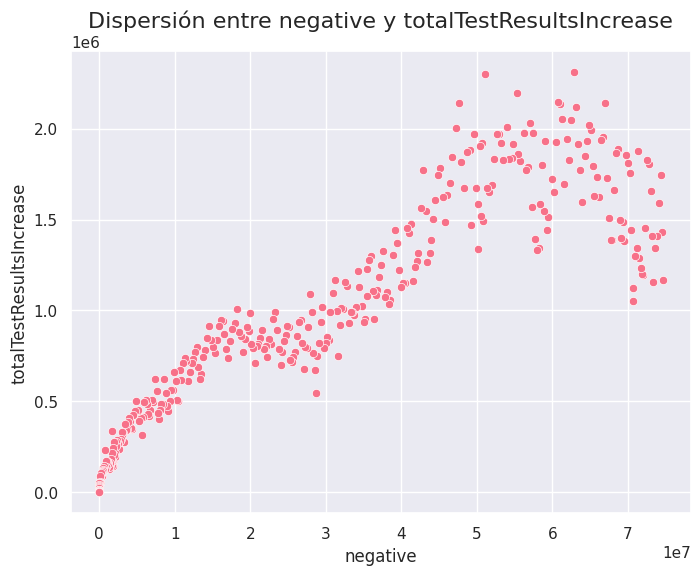

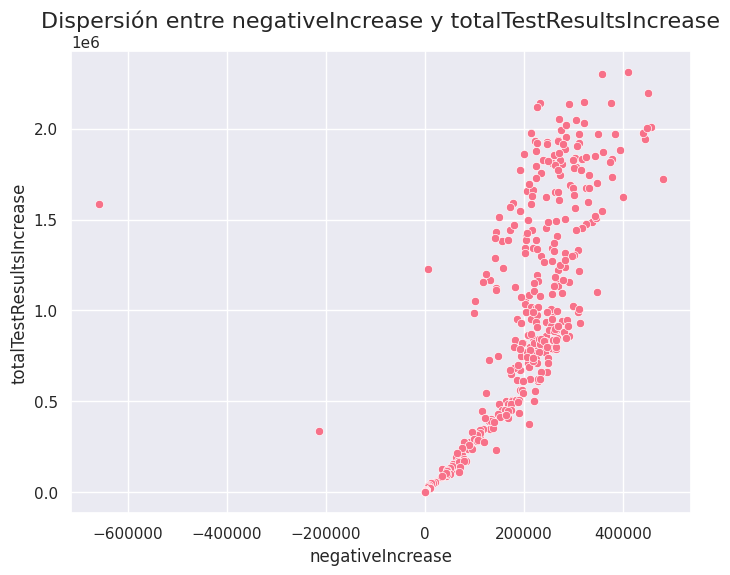

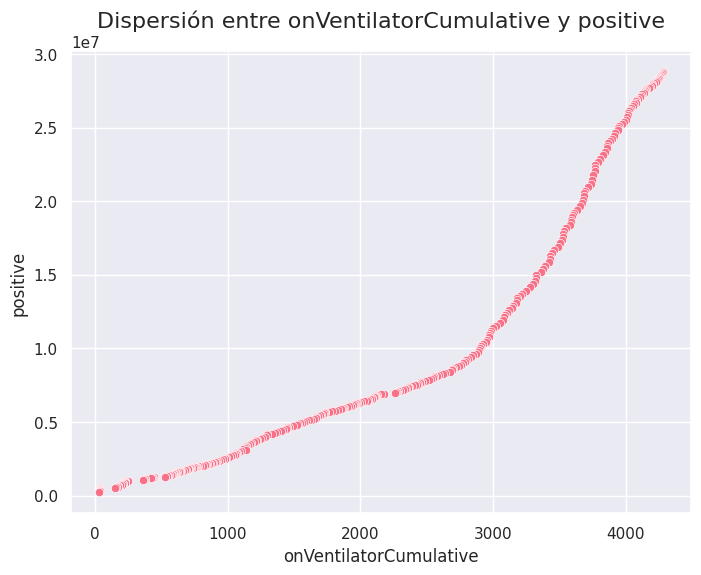

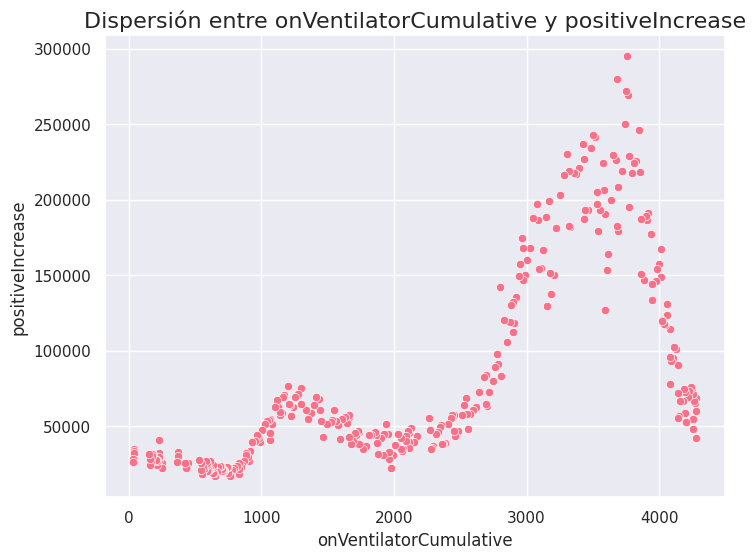

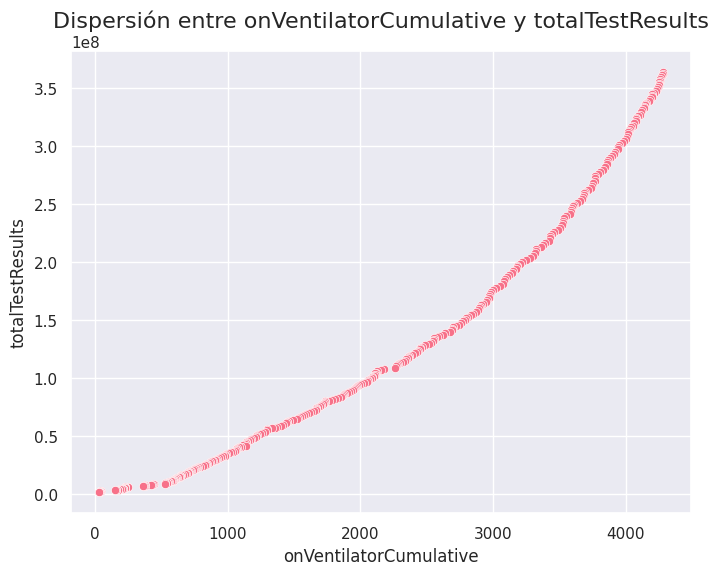

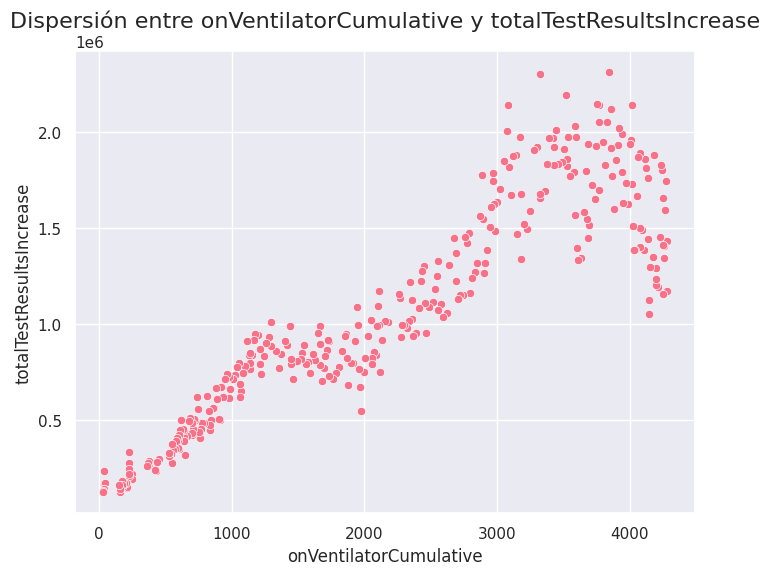

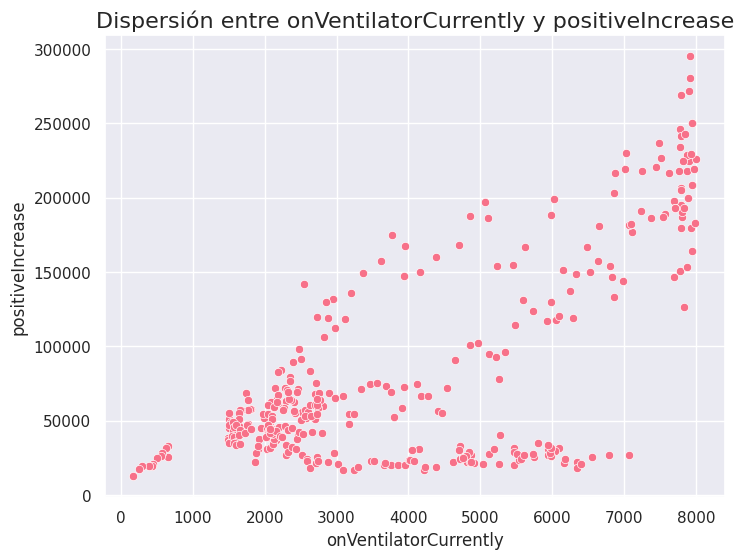

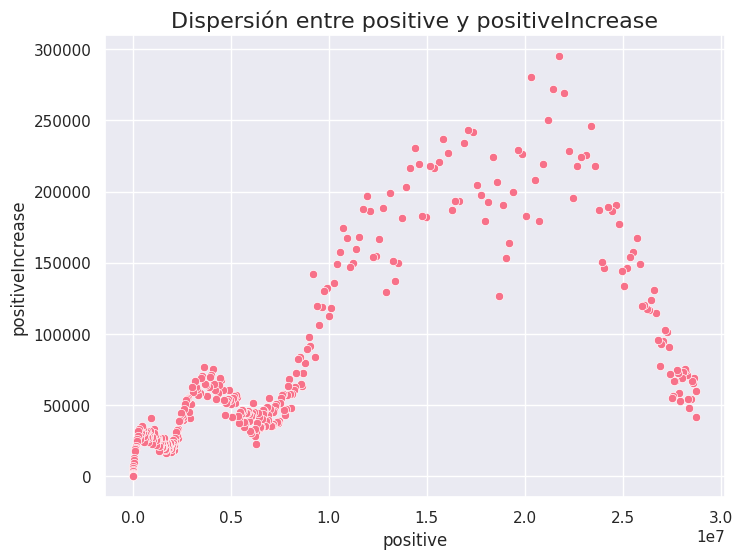

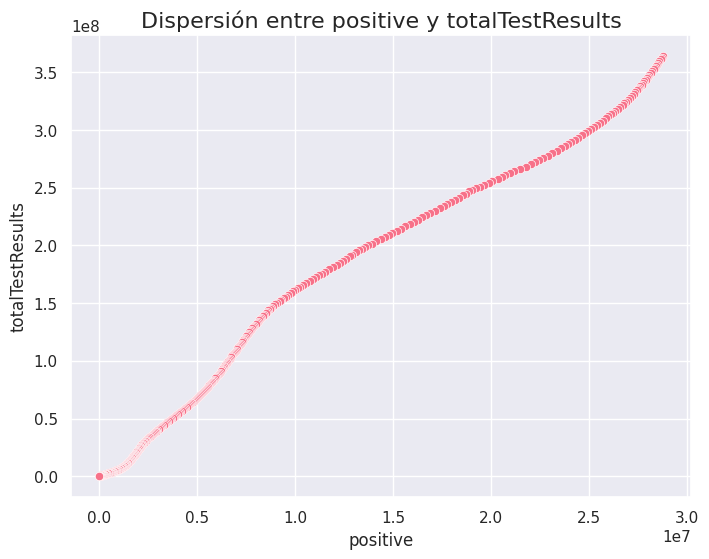

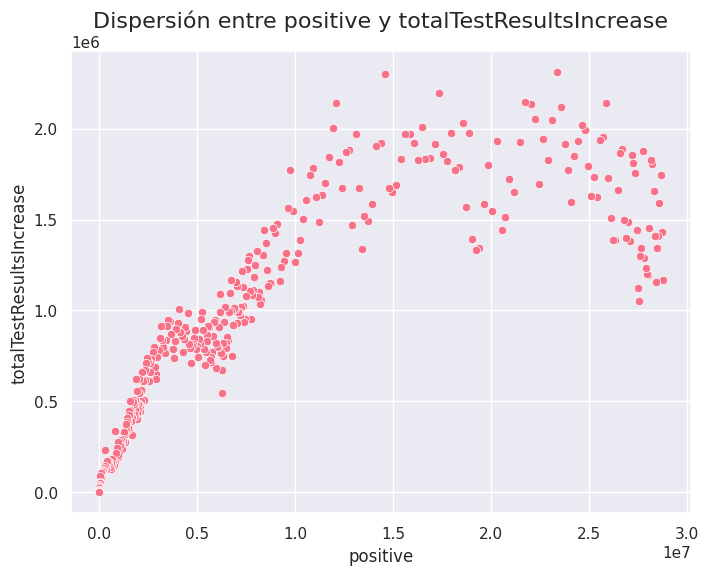

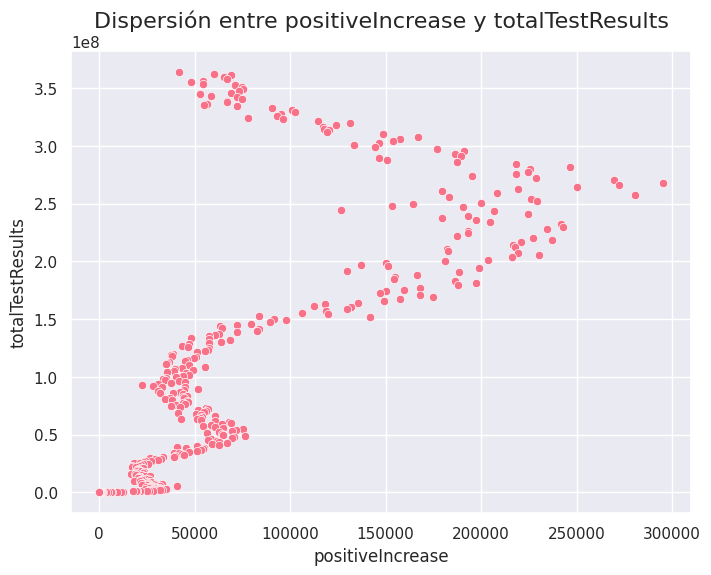

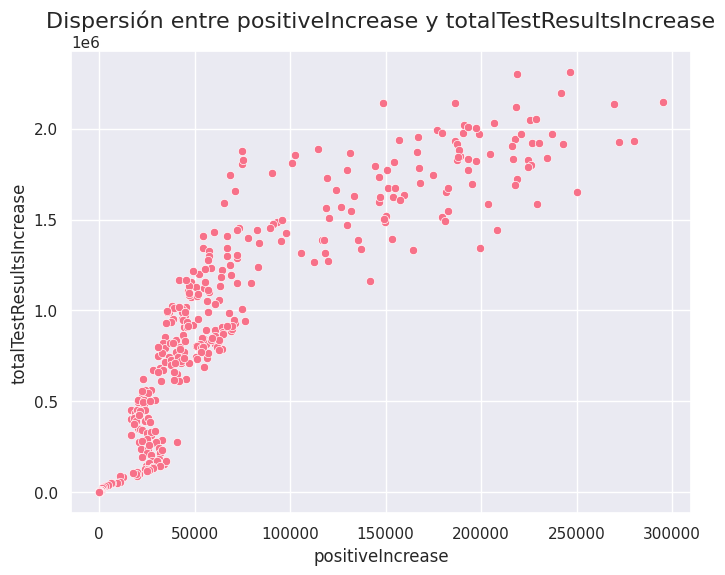

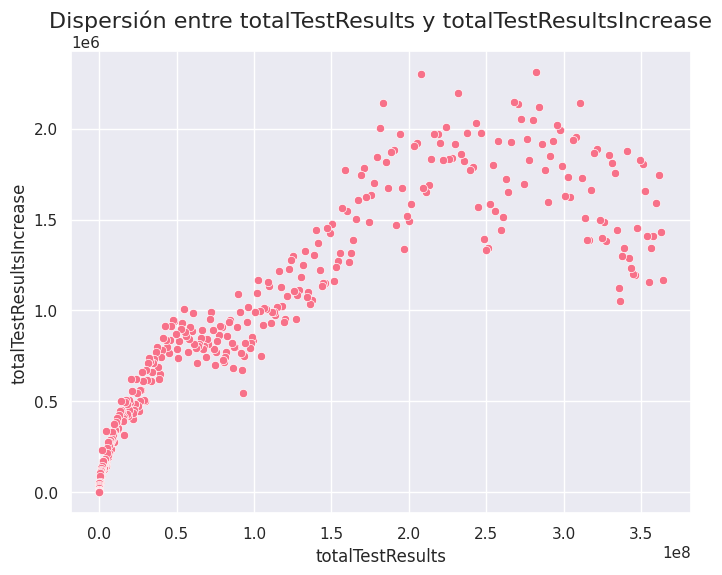

=== ANÁLISIS DE VALORES ATÍPICOS ===

death: 0 valores atípicos encontrados


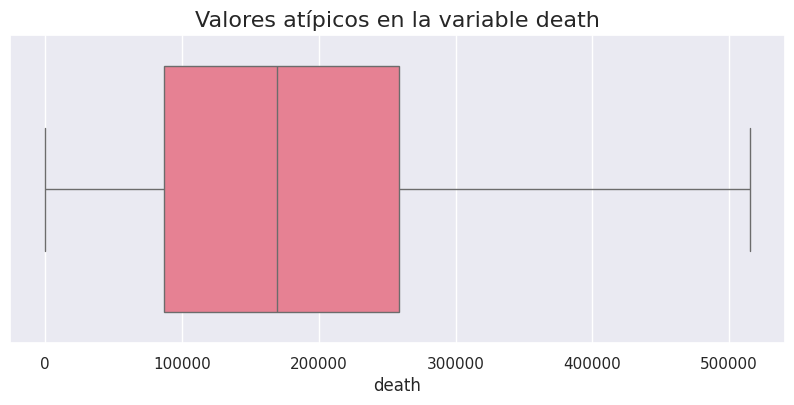

deathIncrease: 28 valores atípicos encontrados


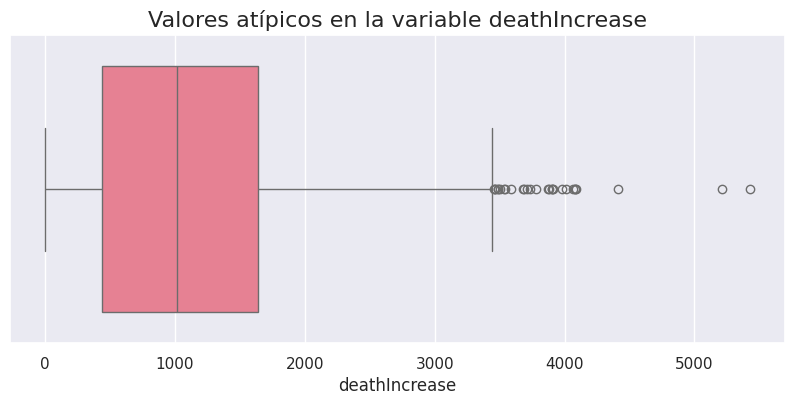

inIcuCumulative: 0 valores atípicos encontrados


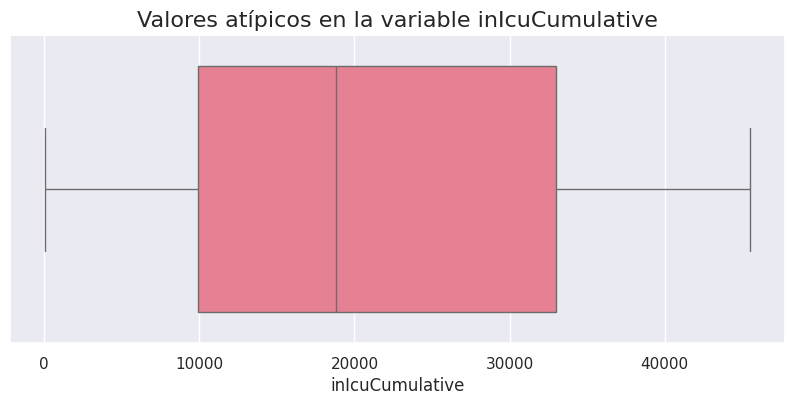

inIcuCurrently: 0 valores atípicos encontrados


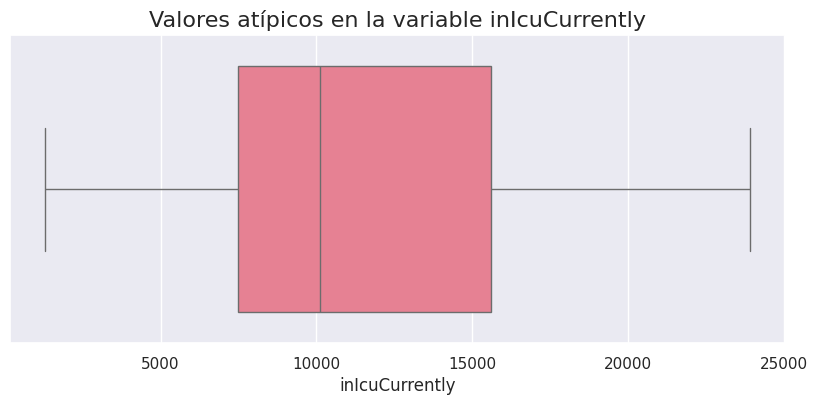

hospitalizedIncrease: 20 valores atípicos encontrados


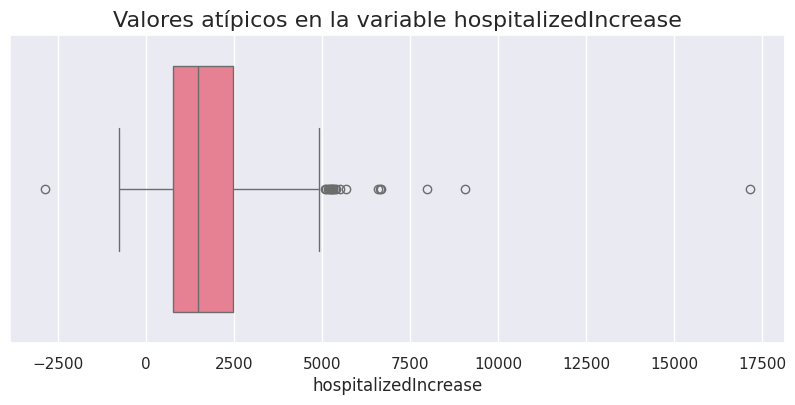

hospitalizedCurrently: 21 valores atípicos encontrados


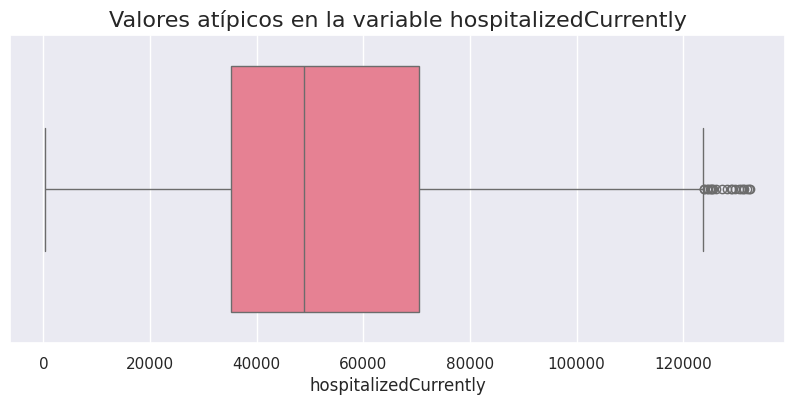

hospitalizedCumulative: 0 valores atípicos encontrados


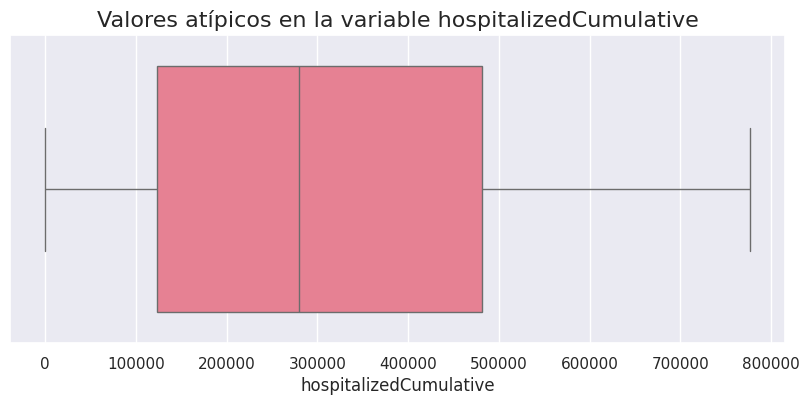

negative: 0 valores atípicos encontrados


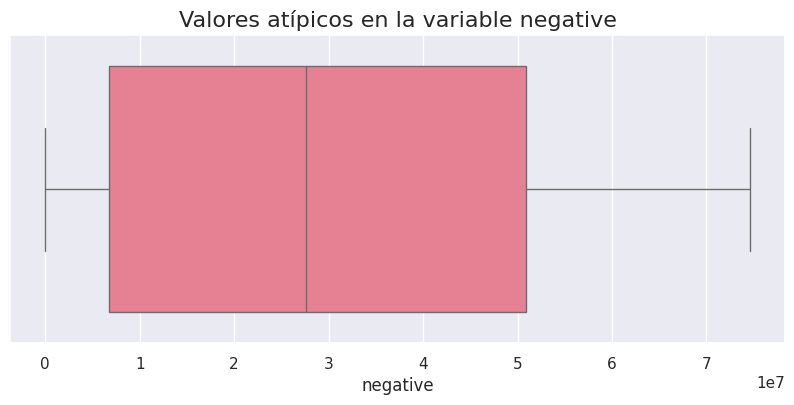

negativeIncrease: 2 valores atípicos encontrados


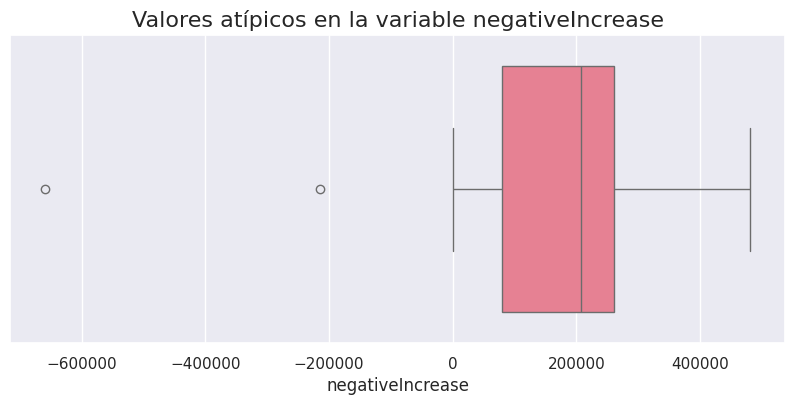

onVentilatorCumulative: 0 valores atípicos encontrados


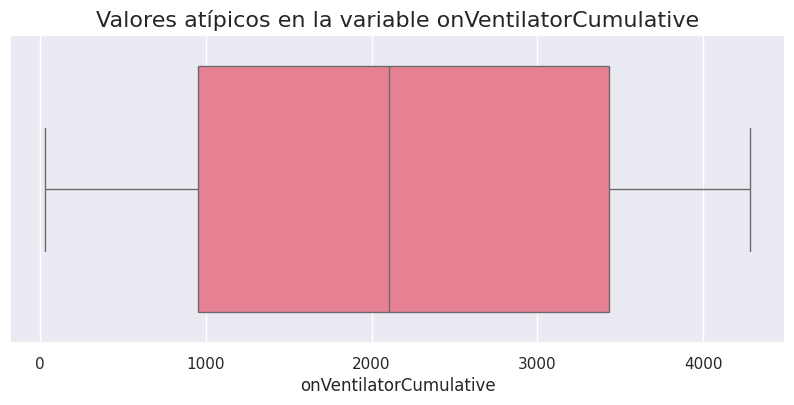

onVentilatorCurrently: 0 valores atípicos encontrados


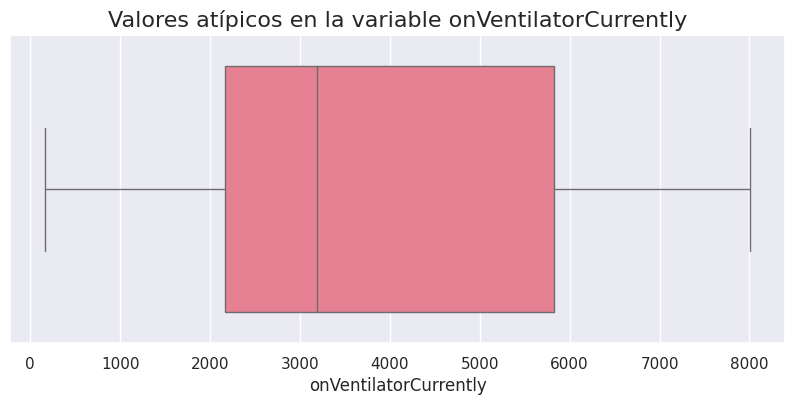

positive: 0 valores atípicos encontrados


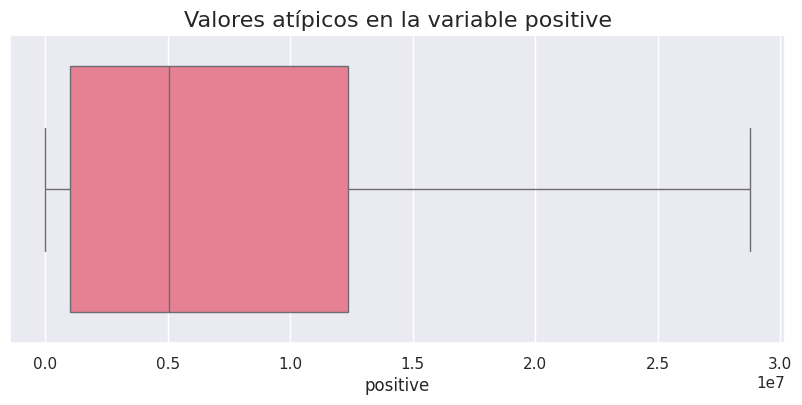

positiveIncrease: 40 valores atípicos encontrados


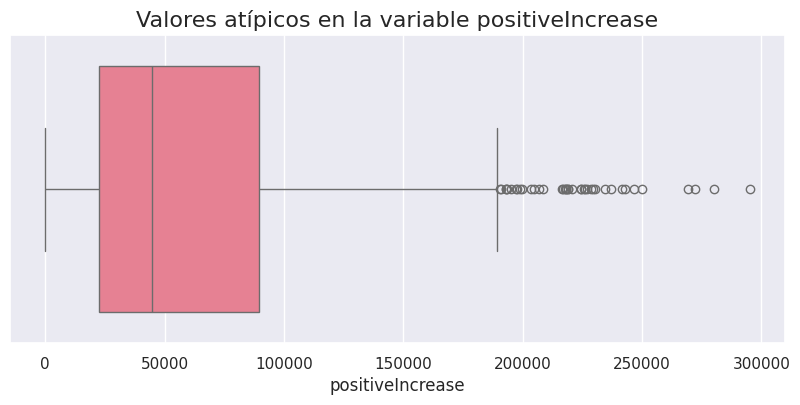

states: 63 valores atípicos encontrados


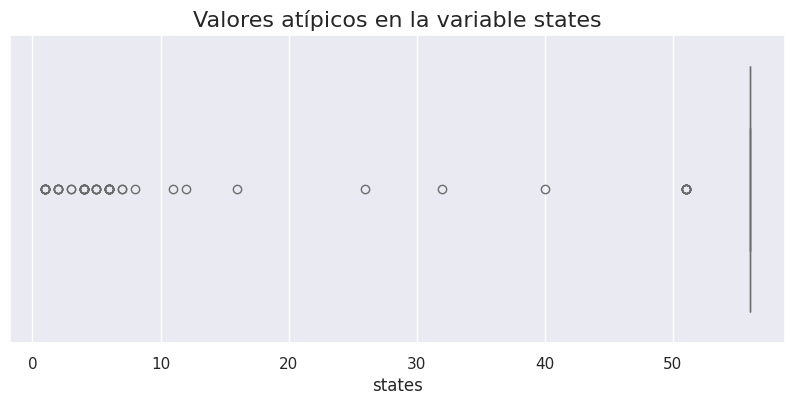

totalTestResults: 0 valores atípicos encontrados


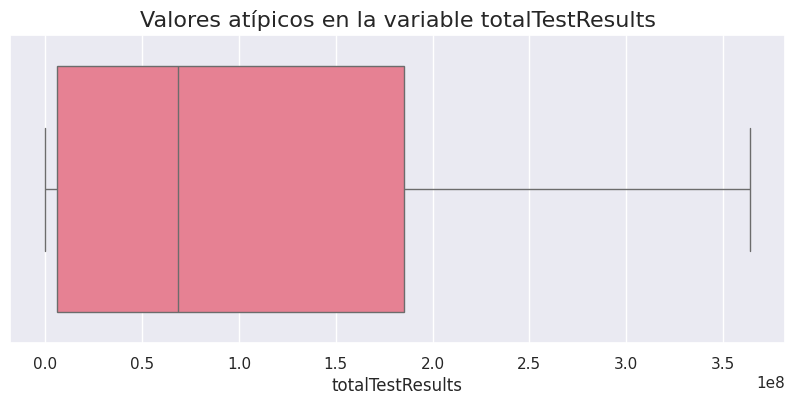

totalTestResultsIncrease: 0 valores atípicos encontrados


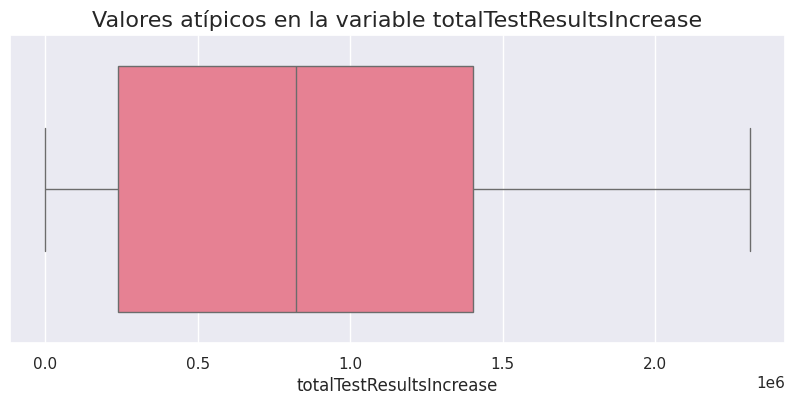

=== ANÁLISIS TEMPORAL ===

No se pudo realizar el análisis temporal para positive: This function does not handle missing values
No se pudo realizar el análisis temporal para death: This function does not handle missing values
No se pudo realizar el análisis temporal para hospitalizedCurrently: This function does not handle missing values


In [39]:
def realizar_eda(filepath):
    df = cargar_datos(filepath)
    if df is None:
        return
    if not verificar_columnas(df):
        return

    inspeccion_inicial(df)
    analisis_valores_faltantes(df)
    analisis_variables_numericas(df)
    analisis_variables_categoricas(df)
    analisis_correlaciones(df)
    analisis_valores_atipicos(df)
    analisis_temporal(df)


# Ejecutar el EDA
realizar_eda('/home/leire/Documentos/F5/Proyectos/Mini_dathaton_COVID/repositorio_COVID/COVID_Leire-1/national-history.csv')